# Dummy

In [3]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Lire les données
app_train = pd.read_csv('data/application_train_split.csv')
app_test = pd.read_csv('data/application_test_split.csv')

# Séparer les données d'entraînement
if 'TARGET' in app_train:
    train = app_train.drop(columns=['TARGET'])
    train_labels = app_train['TARGET']
else:
    raise ValueError("La colonne 'TARGET' n'existe pas dans les données d'entraînement.")

# Préparer les colonnes numériques
numeric_cols = train.select_dtypes(include=['number']).columns

# Imputer les valeurs manquantes pour les colonnes numériques
imputer = SimpleImputer(strategy='median')
train_numeric = imputer.fit_transform(train[numeric_cols])
test_numeric = imputer.transform(app_test[numeric_cols])

# Normaliser les colonnes numériques
scaler = MinMaxScaler(feature_range=(0, 1))
train_numeric = scaler.fit_transform(train_numeric)
test_numeric = scaler.transform(test_numeric)

# Créer et entraîner le DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(train_numeric, train_labels)

# Faire des prédictions sur les données d'entraînement (pour évaluation)
train_predictions = dummy_clf.predict(train_numeric)

# Calculer le score de précision sur les données d'entraînement
train_score = accuracy_score(train_labels, train_predictions)

# Faire des prédictions sur les données de test
dummy_predictions = dummy_clf.predict(test_numeric)

# Créer le DataFrame de soumission
submit = app_test[['SK_ID_CURR']].copy()
submit['TARGET'] = dummy_predictions

# Afficher les résultats
print("Score du modèle sur les données d'entraînement :", train_score)
print(submit.head())


Score du modèle sur les données d'entraînement : 0.8515727711526222
   SK_ID_CURR  TARGET
0      342180       0
1      259636       0
2      305882       0
3      243264       0
4      264946       0


# Regression logistique

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import pandas as pd

# Charger les données
app_train = pd.read_csv('data/application_train_split.csv')
app_test = pd.read_csv('data/application_test_split.csv')

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns=['TARGET'])
    train_labels = app_train['TARGET']
else:
    train = app_train.copy()

# Séparer les colonnes numériques et non numériques
numeric_cols = train.select_dtypes(include=['number']).columns
categorical_cols = train.select_dtypes(exclude=['number']).columns

# Imputation des valeurs manquantes pour les colonnes numériques
imputer = SimpleImputer(strategy='median')
train_numeric = imputer.fit_transform(train[numeric_cols])
test_numeric = imputer.transform(app_test[numeric_cols])

# Normalisation des colonnes numériques
scaler = MinMaxScaler(feature_range=(0, 1))
train_numeric = scaler.fit_transform(train_numeric)
test_numeric = scaler.transform(test_numeric)
train_final = pd.DataFrame(train_numeric, columns=numeric_cols)
test_final = pd.DataFrame(test_numeric, columns=numeric_cols)

# Créer et entraîner le modèle
log_reg = LogisticRegression(C=0.0001)
log_reg.fit(train_final, train_labels)

# Faire des prédictions sur les données d'entraînement
train_pred = log_reg.predict_proba(train_final)[:, 1]

# Calculer le score ROC AUC sur les données d'entraînement
roc_auc = roc_auc_score(train_labels, train_pred)

# Afficher le score ROC AUC
print(f'ROC AUC Score: {roc_auc:.4f}')

# Faire des prédictions sur l'ensemble de test
log_reg_pred = log_reg.predict_proba(test_final)[:, 1]

# Créer le DataFrame de soumission
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()


ROC AUC Score: 0.6831


/var/folders/25/t6v1433n06x6vfl9wjbxn8sw0000gn/T/ipykernel_82143/2695516506.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['TARGET'] = log_reg_pred


,SK_ID_CURR,TARGET
0,342180,0.081685
1,259636,0.064739
2,305882,0.077060
3,243264,0.063606
4,264946,0.064830


# Arbre de décision

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import pandas as pd

# Charger les données
app_train = pd.read_csv('data/application_train_split.csv')
app_test = pd.read_csv('data/application_test_split.csv')

# Convertir toutes les colonnes en numériques en utilisant LabelEncoder
label_encoders = {}
for col in app_train.columns:
    if app_train[col].dtype == 'object':
        le = LabelEncoder()
        app_train[col] = le.fit_transform(app_train[col].astype(str))
        if col in app_test.columns:
            app_test[col] = le.transform(app_test[col].astype(str))
        label_encoders[col] = le

# Séparer les données d'entraînement et les labels
if 'TARGET' in app_train:
    train = app_train.drop(columns=['TARGET'])
    train_labels = app_train['TARGET']
else:
    train = app_train.copy()
    train_labels = None

# Préparer les données de test sans l'identifiant
test = app_test.drop(columns=['SK_ID_CURR'])

# S'assurer que les colonnes sont alignées avant l'imputation
common_cols = train.columns.intersection(test.columns)
train = train[common_cols]
test = test[common_cols]

# Imputer les valeurs manquantes avec la médiane
imputer = SimpleImputer(strategy='median')
train = imputer.fit_transform(train)
test = imputer.transform(test)

# Créer le modèle d'Arbre de Décision avec des hyperparamètres
decision_tree = DecisionTreeClassifier(max_depth=7, min_samples_split=10, min_samples_leaf=5)

# Entraîner le modèle
decision_tree.fit(train, train_labels)

# Faire des prédictions sur les données d'entraînement
train_pred = decision_tree.predict_proba(train)[:, 1]

# Calculer le score ROC AUC sur les données d'entraînement
roc_auc = roc_auc_score(train_labels, train_pred)

# Afficher le score ROC AUC
print(f'ROC AUC Score: {roc_auc:.4f}')

# Extraire l'importance des caractéristiques
feature_importance_values = decision_tree.feature_importances_
feature_importances = pd.DataFrame({'feature': common_cols, 'importance': feature_importance_values})

# Faire des prédictions sur l'ensemble de test
predictions = decision_tree.predict_proba(test)[:, 1]

# Créer le DataFrame de soumission
submit = pd.DataFrame({'SK_ID_CURR': app_test['SK_ID_CURR'], 'TARGET': predictions})

print("Prédictions:")
print(submit.head())


ROC AUC Score: 0.7277
Prédictions:
   SK_ID_CURR    TARGET
0      342180  0.045878
1      259636  0.079470
2      305882  0.045878
3      243264  0.037365
4      264946  0.061666


# Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import pandas as pd

# Charger les données
app_train = pd.read_csv('data/application_train_split.csv')
app_test = pd.read_csv('data/application_test_split.csv')

# Convertir toutes les colonnes en numériques en utilisant LabelEncoder
label_encoders = {}
for col in app_train.columns:
    if app_train[col].dtype == 'object':
        le = LabelEncoder()
        app_train[col] = le.fit_transform(app_train[col].astype(str))
        if col in app_test.columns:
            app_test[col] = le.transform(app_test[col].astype(str))
        label_encoders[col] = le

# Séparer les données d'entraînement et les labels
if 'TARGET' in app_train:
    train = app_train.drop(columns=['TARGET'])
    train_labels = app_train['TARGET']
else:
    train = app_train.copy()
    train_labels = None

# Préparer les données de test sans l'identifiant
test = app_test.drop(columns=['SK_ID_CURR'])

# S'assurer que les colonnes sont alignées avant l'imputation
common_cols = train.columns.intersection(test.columns)
train = train[common_cols]
test = test[common_cols]

# Imputer les valeurs manquantes avec la médiane
imputer = SimpleImputer(strategy='median')
train = imputer.fit_transform(train)
test = imputer.transform(test)

# Créer le modèle RandomForest
random_forest = RandomForestClassifier(n_estimators=1, verbose=1, n_jobs=-1)

# Entraîner le modèle
random_forest.fit(train, train_labels)

# Faire des prédictions sur les données d'entraînement
train_pred = random_forest.predict_proba(train)[:, 1]

# Calculer le score ROC AUC sur les données d'entraînement
roc_auc = roc_auc_score(train_labels, train_pred)

# Afficher le score ROC AUC
print(f'ROC AUC Score: {roc_auc:.4f}')

# Extraire l'importance des caractéristiques
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': common_cols, 'importance': feature_importance_values})

# Faire des prédictions sur l'ensemble de test
predictions = random_forest.predict_proba(test)[:, 1]

# Créer le DataFrame de soumission
submit = pd.DataFrame({'SK_ID_CURR': app_test['SK_ID_CURR'], 'TARGET': predictions})

print("Prédictions:")
print(submit.head())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


ROC AUC Score: 0.8279
Prédictions:
   SK_ID_CURR  TARGET
0      342180     0.0
1      259636     0.0
2      305882     0.0
3      243264     0.0
4      264946     0.0


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


# Sans CV

In [162]:
def process_and_predict(train_file, test_file):
    # Configurer le logging pour ignorer les messages d'information de LightGBM
    logging.getLogger('lightgbm').setLevel(logging.ERROR)
    
    # Rediriger stdout pour éviter les messages d'information de LightGBM
    original_stdout = sys.stdout
    sys.stdout = open('/dev/null', 'w')  # Sur Unix/Linux/Mac
    
    # Charger les données
    app_train = pd.read_csv(train_file)
    app_test = pd.read_csv(test_file)
    
    # Convertir toutes les colonnes en numériques en utilisant LabelEncoder
    label_encoders = {}
    for col in app_train.columns:
        if app_train[col].dtype == 'object':
            le = LabelEncoder()
            app_train[col] = le.fit_transform(app_train[col].astype(str))
            if col in app_test.columns:
                app_test[col] = le.transform(app_test[col].astype(str))
            label_encoders[col] = le
    
    # Séparer les données d'entraînement et les labels
    if 'TARGET' in app_train:
        train = app_train.drop(columns=['TARGET'])
        train_labels = app_train['TARGET']
    else:
        raise ValueError("La colonne 'TARGET' n'existe pas dans les données d'entraînement.")
    
    # Vérifier que les données de test contiennent également la colonne 'TARGET'
    if 'TARGET' in app_test:
        test = app_test.drop(columns=['SK_ID_CURR', 'TARGET'])
        test_labels = app_test['TARGET']
    else:
        raise ValueError("La colonne 'TARGET' n'existe pas dans les données de test.")
    
    # S'assurer que les colonnes sont alignées avant l'imputation
    common_cols = train.columns.intersection(test.columns)
    train = train[common_cols]
    test = test[common_cols]
    
    # Imputer les valeurs manquantes avec la médiane
    imputer = SimpleImputer(strategy='median')
    train_numeric = imputer.fit_transform(train)
    test_numeric = imputer.transform(test)
    
    # Normaliser les colonnes numériques
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_numeric = scaler.fit_transform(train_numeric)
    test_numeric = scaler.transform(test_numeric)
    
    # Convertir les matrices numpy en DataFrames pandas
    train_final = pd.DataFrame(train_numeric, columns=common_cols)
    test_final = pd.DataFrame(test_numeric, columns=common_cols)
    
    # Créer et entraîner le DummyClassifier
    dummy_clf = DummyClassifier(strategy="stratified")
    dummy_clf.fit(train_final, train_labels)
    dummy_predictions = dummy_clf.predict_proba(test_final)[:, 1]
    dummy_auc = roc_auc_score(train_labels, dummy_clf.predict_proba(train_final)[:, 1])
    dummy_time = measure_prediction_time(dummy_clf, test_final)
    
    # Entraîner le LogisticRegression sans GridSearchCV
    log_reg = LogisticRegression(C=1750, max_iter=9000)
    log_reg.fit(train_final, train_labels)
    log_reg_auc = roc_auc_score(train_labels, log_reg.predict_proba(train_final)[:, 1])
    log_reg_time = measure_prediction_time(log_reg, test_final)
    
    # Entraîner le DecisionTreeClassifier sans GridSearchCV
    decision_tree = DecisionTreeClassifier(max_depth=7, min_samples_split=20)
    decision_tree.fit(train_final, train_labels)
    tree_auc = roc_auc_score(train_labels, decision_tree.predict_proba(train_final)[:, 1])
    tree_time = measure_prediction_time(decision_tree, test_final)
    
    # Entraîner le RandomForestClassifier sans GridSearchCV
    random_forest = RandomForestClassifier(n_estimators=100, max_depth=7, n_jobs=-1)
    random_forest.fit(train_final, train_labels)
    rf_auc = roc_auc_score(train_labels, random_forest.predict_proba(train_final)[:, 1])
    rf_time = measure_prediction_time(random_forest, test_final)
    
    # Entraîner le CatBoostClassifier sans GridSearchCV
    catboost_model = CatBoostClassifier(iterations=100, depth=3, learning_rate=0.1, loss_function='Logloss', verbose=0)
    catboost_model.fit(train_final, train_labels)
    catboost_auc = roc_auc_score(train_labels, catboost_model.predict_proba(train_final)[:, 1])
    catboost_predictions = catboost_model.predict_proba(test_final)[:, 1]
    catboost_time = measure_prediction_time(catboost_model, test_final)
    
    # Entraîner le LightGBMClassifier sans GridSearchCV
    lightgbm_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, num_leaves=31)
    lightgbm_model.fit(train_final, train_labels)
    lightgbm_auc = roc_auc_score(train_labels, lightgbm_model.predict_proba(train_final)[:, 1])
    lightgbm_predictions = lightgbm_model.predict_proba(test_final)[:, 1]
    lightgbm_time = measure_prediction_time(lightgbm_model, test_final)
    
    # Rétablir stdout
    sys.stdout = original_stdout

    # Calcul des métriques pour chaque modèle sur les données d'entraînement
    models = {
        'DummyClassifier': dummy_clf,
        'LogisticRegression': log_reg,
        'DecisionTreeClassifier': decision_tree,
        'RandomForestClassifier': random_forest,
        'CatBoostClassifier': catboost_model,
        'LightGBMClassifier': lightgbm_model
    }

    metrics_train = []
    metrics_test = []

    for name, model in models.items():
        # Calcul des métriques sur les données d'entraînement
        train_pred = model.predict(train_final)
        auc_train = roc_auc_score(train_labels, model.predict_proba(train_final)[:, 1])
        precision_train = precision_score(train_labels, train_pred, zero_division=0)
        recall_train = recall_score(train_labels, train_pred, zero_division=0)
        f1_train = f1_score(train_labels, train_pred, zero_division=0)
        cm_train = confusion_matrix(train_labels, train_pred)
        cm_train_str = f"TN: {cm_train[0, 0]}, FP: {cm_train[0, 1]}, FN: {cm_train[1, 0]}, TP: {cm_train[1, 1]}"
        time_metric_train = measure_prediction_time(model, test_final)
        metrics_train.append([
            name,
            f"{auc_train:.5f}",
            f"{precision_train:.5f}",
            f"{recall_train:.5f}",
            f"{f1_train:.5f}",
            cm_train_str,
            time_metric_train
        ])
        
        # Calcul des métriques sur les données de test
        test_pred = model.predict(test_final)
        auc_test = roc_auc_score(test_labels, model.predict_proba(test_final)[:, 1])
        precision_test = precision_score(test_labels, test_pred, zero_division=0)
        recall_test = recall_score(test_labels, test_pred, zero_division=0)
        f1_test = f1_score(test_labels, test_pred, zero_division=0)
        cm_test = confusion_matrix(test_labels, test_pred)
        cm_test_str = f"TN: {cm_test[0, 0]}, FP: {cm_test[0, 1]}, FN: {cm_test[1, 0]}, TP: {cm_test[1, 1]}"
        time_metric_test = measure_prediction_time(model, test_final)
        metrics_test.append([
            name,
            f"{auc_test:.5f}",
            f"{precision_test:.5f}",
            f"{recall_test:.5f}",
            f"{f1_test:.5f}",
            cm_test_str,
            time_metric_test
        ])
    
    # Affichage des résultats
    headers = ['Model', 'ROC AUC', 'Precision', 'Recall', 'F1 Score', 'Confusion Matrix', '1000 Predictions (s)']
    results_train_table = tabulate(metrics_train, headers, tablefmt='pipe')
    results_test_table = tabulate(metrics_test, headers, tablefmt='pipe')
    
    print("Résultats des modèles sur les données d'entraînement :")
    print(results_train_table)
    print("\nRésultats des modèles sur les données de test :")
    print(results_test_table)
    
    return {
        'DummyClassifier': dummy_predictions,
        'LogisticRegression': log_reg.predict_proba(test_final)[:, 1],
        'DecisionTreeClassifier': decision_tree.predict_proba(test_final)[:, 1],
        'RandomForestClassifier': random_forest.predict_proba(test_final)[:, 1],
        'CatBoostClassifier': catboost_predictions,
        'LightGBMClassifier': lightgbm_predictions
    }
predictions = process_and_predict('data/application_train_split.csv', 'data/application_test_split.csv')


Résultats des modèles sur les données d'entraînement :
| Model                  |   ROC AUC |   Precision |   Recall |   F1 Score | Confusion Matrix                           |   1000 Predictions (s) |
|:-----------------------|----------:|------------:|---------:|-----------:|:-------------------------------------------|-----------------------:|
| DummyClassifier        |   0.49887 |     0.08034 |  0.08056 |    0.08045 | TN: 182019, FP: 15946, FN: 15899, TP: 1393 |                1.6471  |
| LogisticRegression     |   0.7473  |     0.44416 |  0.00989 |    0.01935 | TN: 197751, FP: 214, FN: 17121, TP: 171    |                4.38154 |
| DecisionTreeClassifier |   0.72612 |     0.72241 |  0.01249 |    0.02456 | TN: 197882, FP: 83, FN: 17076, TP: 216     |                8.40636 |
| RandomForestClassifier |   0.75781 |     0       |  0       |    0       | TN: 197965, FP: 0, FN: 17292, TP: 0        |               46.1887  |
| CatBoostClassifier     |   0.7508  |     0.57143 |  0.00717 |

# Fonction unique avec CV

In [115]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
import lightgbm as lgb
import logging
import sys
import time
from tabulate import tabulate

def measure_prediction_time(model, X, n_predictions=1000):
    """Mesurer le temps de prédiction moyen sur n_predictions échantillons."""
    start_time = time.time()
    for _ in range(n_predictions):
        _ = model.predict_proba(X)[:, 1]
    end_time = time.time()
    elapsed_time = end_time - start_time
    return "{:.2f} s".format(elapsed_time)

def process_and_predict(train_file, test_file):
    # Configurer le logging pour ignorer les messages d'information de LightGBM
    logging.getLogger('lightgbm').setLevel(logging.ERROR)
    
    # Rediriger stdout pour éviter les messages d'information de LightGBM
    original_stdout = sys.stdout
    sys.stdout = open('/dev/null', 'w')  # Sur Unix/Linux/Mac
    
    # Charger les données
    app_train = pd.read_csv(train_file)
    app_test = pd.read_csv(test_file)
    
    # Convertir toutes les colonnes en numériques en utilisant LabelEncoder
    label_encoders = {}
    for col in app_train.columns:
        if app_train[col].dtype == 'object':
            le = LabelEncoder()
            app_train[col] = le.fit_transform(app_train[col].astype(str))
            if col in app_test.columns:
                app_test[col] = le.transform(app_test[col].astype(str))
            label_encoders[col] = le
    
    # Séparer les données d'entraînement et les labels
    if 'TARGET' in app_train:
        train = app_train.drop(columns=['TARGET'])
        train_labels = app_train['TARGET']
    else:
        raise ValueError("La colonne 'TARGET' n'existe pas dans les données d'entraînement.")
    
    # Préparer les données de test sans l'identifiant
    test = app_test.drop(columns=['SK_ID_CURR'])
    
    # S'assurer que les colonnes sont alignées avant l'imputation
    common_cols = train.columns.intersection(test.columns)
    train = train[common_cols]
    test = test[common_cols]
    
    # Imputer les valeurs manquantes avec la médiane
    imputer = SimpleImputer(strategy='median')
    train_numeric = imputer.fit_transform(train)
    test_numeric = imputer.transform(test)
    
    # Normaliser les colonnes numériques
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_numeric = scaler.fit_transform(train_numeric)
    test_numeric = scaler.transform(test_numeric)
    
    # Convertir les matrices numpy en DataFrames pandas
    train_final = pd.DataFrame(train_numeric, columns=common_cols)
    test_final = pd.DataFrame(test_numeric, columns=common_cols)
    
    # Créer et entraîner le DummyClassifier
    dummy_clf = DummyClassifier(strategy="stratified")
    dummy_clf.fit(train_final, train_labels)
    dummy_predictions = dummy_clf.predict_proba(test_final)[:, 1]
    dummy_auc = roc_auc_score(train_labels, dummy_clf.predict_proba(train_final)[:, 1])
    dummy_time = measure_prediction_time(dummy_clf, test_final)
    
    # Définir les paramètres pour GridSearchCV pour LogisticRegression
    log_reg_params = {'C': [1750,1500]}
    log_reg = LogisticRegression(max_iter=9000)
    log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='roc_auc')
    log_reg_grid.fit(train_final, train_labels)
    log_reg_auc = roc_auc_score(train_labels, log_reg_grid.predict_proba(train_final)[:, 1])
    log_reg_time = measure_prediction_time(log_reg_grid, test_final)
    
    # Définir les paramètres pour GridSearchCV pour DecisionTreeClassifier
    tree_params = {'max_depth': [5, 7, 10], 'min_samples_split': [10, 20, 50]}
    decision_tree = DecisionTreeClassifier()
    tree_grid = GridSearchCV(decision_tree, tree_params, cv=5, scoring='roc_auc')
    tree_grid.fit(train_final, train_labels)
    tree_auc = roc_auc_score(train_labels, tree_grid.predict_proba(train_final)[:, 1])
    tree_time = measure_prediction_time(tree_grid, test_final)
    
    # Définir les paramètres pour GridSearchCV pour RandomForestClassifier
    rf_params = {'n_estimators': [10, 50, 100], 'max_depth': [5, 7, 10]}
    random_forest = RandomForestClassifier(n_jobs=-1)
    rf_grid = GridSearchCV(random_forest, rf_params, cv=5, scoring='roc_auc')
    rf_grid.fit(train_final, train_labels)
    rf_auc = roc_auc_score(train_labels, rf_grid.predict_proba(train_final)[:, 1])
    rf_time = measure_prediction_time(rf_grid, test_final)
    
    # Définir les paramètres pour GridSearchCV pour CatBoostClassifier
    catboost_params = {'depth': [1,2, 3,4, 5], 'learning_rate': [0.01, 0.1, 0.3]}
    catboost_model = CatBoostClassifier(iterations=100, loss_function='Logloss', verbose=0)
    catboost_grid = GridSearchCV(catboost_model, catboost_params, cv=5, scoring='roc_auc')
    catboost_grid.fit(train_final, train_labels)
    catboost_auc = roc_auc_score(train_labels, catboost_grid.predict_proba(train_final)[:, 1])
    catboost_predictions = catboost_grid.predict_proba(test_final)[:, 1]
    catboost_time = measure_prediction_time(catboost_grid, test_final)
    
    # Définir les paramètres pour GridSearchCV pour LightGBMClassifier
    lightgbm_params = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [1,2, 3,4, 5],
        'num_leaves': [2**6 - 1, 2**7 - 1, 2**8 - 1]  # Ajusté pour respecter la condition
    }
    lightgbm_model = lgb.LGBMClassifier()
    lightgbm_grid = GridSearchCV(lightgbm_model, lightgbm_params, cv=5, scoring='roc_auc')
    lightgbm_grid.fit(train_final, train_labels)
    lightgbm_auc = roc_auc_score(train_labels, lightgbm_grid.predict_proba(train_final)[:, 1])
    lightgbm_predictions = lightgbm_grid.predict_proba(test_final)[:, 1]
    lightgbm_time = measure_prediction_time(lightgbm_grid, test_final)
    
    # Rétablir stdout
    sys.stdout = original_stdout

    # Afficher les meilleurs hyperparamètres pour chaque modèle
    best_params = {
        'LogisticRegression': log_reg_grid.best_params_,
        'DecisionTreeClassifier': tree_grid.best_params_,
        'RandomForestClassifier': rf_grid.best_params_,
        'CatBoostClassifier': catboost_grid.best_params_,
        'LightGBMClassifier': lightgbm_grid.best_params_
    }
    
    print("Meilleurs hyperparamètres pour chaque modèle :")
    for model_name, params in best_params.items():
        print(f"{model_name}: {params}")
    
    # Calcul des métriques pour chaque modèle
    models = {
        'DummyClassifier': dummy_clf,
        'LogisticRegression': log_reg_grid,
        'DecisionTreeClassifier': tree_grid,
        'RandomForestClassifier': rf_grid,
        'CatBoostClassifier': catboost_grid,
        'LightGBMClassifier': lightgbm_grid
    }

    metrics = []

    for name, model in models.items():
        train_pred = model.predict(train_final)
        auc_score = roc_auc_score(train_labels, model.predict_proba(train_final)[:, 1])
        precision = precision_score(train_labels, train_pred, zero_division=0)
        recall = recall_score(train_labels, train_pred, zero_division=0)
        f1 = f1_score(train_labels, train_pred, zero_division=0)
        cm = confusion_matrix(train_labels, train_pred)
        cm_str = f"TN: {cm[0, 0]}, FP: {cm[0, 1]}, FN: {cm[1, 0]}, TP: {cm[1, 1]}"
        time_metric = measure_prediction_time(model, test_final)
        metrics.append([
            name,
            f"{auc_score:.5f}",
            f"{precision:.5f}",
            f"{recall:.5f}",
            f"{f1:.5f}",
            cm_str,
            time_metric
        ])
    
    # Affichage des résultats
    headers = ['Model', 'ROC AUC', 'Precision', 'Recall', 'F1 Score', 'Confusion Matrix', 'Time for 1000 Predictions (s)']
    results_table = tabulate(metrics, headers, tablefmt='grid')
    
    print("Résultats des modèles :")
    print(results_table)
    
    return {
        'DummyClassifier': dummy_predictions,
        'LogisticRegression': log_reg_grid.predict_proba(test_final)[:, 1],
        'DecisionTreeClassifier': tree_grid.predict_proba(test_final)[:, 1],
        'RandomForestClassifier': rf_grid.predict_proba(test_final)[:, 1],
        'CatBoostClassifier': catboost_predictions,
        'LightGBMClassifier': lightgbm_predictions
    }

# Appel de la fonction avec les chemins des fichiers
predictions = process_and_predict('data/application_train_split.csv', 'data/application_test_split.csv')


Meilleurs hyperparamètres pour chaque modèle :
LogisticRegression: {'C': 1750}
DecisionTreeClassifier: {'max_depth': 7, 'min_samples_split': 50}
RandomForestClassifier: {'max_depth': 10, 'n_estimators': 100}
CatBoostClassifier: {'depth': 5, 'learning_rate': 0.3}
LightGBMClassifier: {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 200, 'num_leaves': 63}
Résultats des modèles :
+------------------------+-----------+-------------+----------+------------+--------------------------------------------+---------------------------------+
| Model                  |   ROC AUC |   Precision |   Recall |   F1 Score | Confusion Matrix                           | Time for 1000 Predictions (s)   |
+========================+===========+=============+==========+============+============================================+=================================+
| DummyClassifier        |   0.5     |     0.07669 |  0.07703 |    0.07686 | TN: 181929, FP: 16036, FN: 15960, TP: 1332 | 1.18 s                   

# Pondération

## Preparation

In [119]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

def clean_data(train_file, test_file):
    """Nettoyer et préparer les données pour l'entraînement et le test."""
    print("Début du nettoyage des données...")
    
    # Charger les données
    app_train = pd.read_csv(train_file)
    app_test = pd.read_csv(test_file)
    
    # Convertir toutes les colonnes en numériques en utilisant LabelEncoder
    label_encoders = {}
    for col in app_train.columns:
        if app_train[col].dtype == 'object':
            le = LabelEncoder()
            app_train[col] = le.fit_transform(app_train[col].astype(str))
            if col in app_test.columns:
                app_test[col] = le.transform(app_test[col].astype(str))
            label_encoders[col] = le
    
    # Séparer les données d'entraînement et les labels
    if 'TARGET' in app_train:
        train = app_train.drop(columns=['TARGET'])
        train_labels = app_train['TARGET']
    else:
        raise ValueError("La colonne 'TARGET' n'existe pas dans les données d'entraînement.")
    
    # Préparer les données de test sans l'identifiant
    test = app_test.drop(columns=['SK_ID_CURR'])
    
    # S'assurer que les colonnes sont alignées avant l'imputation
    common_cols = train.columns.intersection(test.columns)
    train = train[common_cols]
    test = test[common_cols]
    
    # Imputer les valeurs manquantes avec la médiane
    imputer = SimpleImputer(strategy='median')
    train_numeric = imputer.fit_transform(train)
    test_numeric = imputer.transform(test)
    
    # Normaliser les colonnes numériques
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_numeric = scaler.fit_transform(train_numeric)
    test_numeric = scaler.transform(test_numeric)
    
    # Convertir les matrices numpy en DataFrames pandas
    train_final = pd.DataFrame(train_numeric, columns=common_cols)
    test_final = pd.DataFrame(test_numeric, columns=common_cols)
    
    print("Fin du nettoyage des données.")
    return train_final, test_final, train_labels, app_test['TARGET']


## Suppression Output

In [122]:
import sys
import os

class SuppressOutput:
    """Context manager to suppress stdout and stderr."""
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr

## Ponderation

In [125]:
def calculate_class_weights(y):
    """Calculer les poids des classes pour un dataset déséquilibré."""
    print("Calcul de la pondération des classes...")
    from sklearn.utils.class_weight import compute_class_weight
    
    classes = np.unique(y)
    class_weights = compute_class_weight('balanced', classes=classes, y=y)
    class_weight_dict = dict(zip(classes, class_weights))
    
    print(f"Pondération des classes: {class_weight_dict}")
    return class_weight_dict


## Recherche des HP

In [128]:
from sklearn.model_selection import GridSearchCV

def search_hyperparameters(train_final, train_labels):
    """Rechercher les meilleurs hyperparamètres pour chaque modèle."""
    print("Début de la recherche des hyperparamètres...")
    
    models = {}
    
    # LogisticRegression
    log_reg_params = {
        'C': [1500,1750], 
        'solver': ['newton-cg', 'lbfgs'], 
        'penalty': ['l2'],
        'class_weight': ['balanced']
    }
    log_reg = LogisticRegression(max_iter=9000, class_weight='balanced')
    log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='roc_auc')
    log_reg_grid.fit(train_final, train_labels)
    models['LogisticRegression'] = log_reg_grid.best_params_
    
    # DecisionTreeClassifier
    tree_params = {'max_depth': [4,6,7], 'min_samples_split': [3, 4, 2]}
    decision_tree = DecisionTreeClassifier(class_weight='balanced')
    tree_grid = GridSearchCV(decision_tree, tree_params, cv=5, scoring='roc_auc')
    tree_grid.fit(train_final, train_labels)
    models['DecisionTreeClassifier'] = tree_grid.best_params_
    
    # RandomForestClassifier
    rf_params = {'n_estimators': [300], 'max_depth': [5, 10,15]}
    random_forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced')
    rf_grid = GridSearchCV(random_forest, rf_params, cv=5, scoring='roc_auc')
    rf_grid.fit(train_final, train_labels)
    models['RandomForestClassifier'] = rf_grid.best_params_
    
    # CatBoostClassifier
    class_weights = calculate_class_weights(train_labels)
    catboost_params = {
        'depth': [2, 3],
        'learning_rate': [0.1,0.15],
        'l2_leaf_reg': [7,6],
        'bagging_temperature': [0.3,0.35],
        'loss_function': ['Logloss'],
        'auto_class_weights': ['Balanced']
    }
    catboost_model = CatBoostClassifier(iterations=500,auto_class_weights='Balanced', verbose=0)
    catboost_grid = GridSearchCV(catboost_model, catboost_params, cv=5, scoring='roc_auc')
    catboost_grid.fit(train_final, train_labels)
    models['CatBoostClassifier'] = catboost_grid.best_params_
    
    # LightGBMClassifier
    lightgbm_params = {
        'n_estimators': [450],
        'learning_rate': [0.1, 0.2],
        'max_depth': [2, 3,],
        'num_leaves': [2**6 - 1, 2**7 - 1, 2**8 - 1],
        'verbosity': [-1]
    }
    lightgbm_model = lgb.LGBMClassifier()
    lightgbm_grid = GridSearchCV(lightgbm_model, lightgbm_params, cv=5, scoring='roc_auc')
    lightgbm_grid.fit(train_final, train_labels)
    models['LightGBMClassifier'] = lightgbm_grid.best_params_
    
    print("Fin de la recherche des hyperparamètres.")
    return models


## Entrainement

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

def train_models(train_final, train_labels, best_params):
    """Entraîne les modèles avec les meilleurs hyperparamètres trouvés et affiche les meilleurs paramètres."""
    print("Début de l'entraînement des modèles...")
    
    models = {}
    
    # Logistic Regression
    print("\nEntraînement du modèle Logistic Regression...")
    log_reg_model = LogisticRegression(max_iter=9000, **best_params['LogisticRegression'])
    log_reg_model.fit(train_final, train_labels)
    models['LogisticRegression'] = log_reg_model
    print("Meilleurs paramètres pour Logistic Regression :")
    print(best_params['LogisticRegression'])
    
    # Decision Tree Classifier
    print("\nEntraînement du modèle Decision Tree Classifier...")
    decision_tree_model = DecisionTreeClassifier(class_weight='balanced', **best_params['DecisionTreeClassifier'])
    decision_tree_model.fit(train_final, train_labels)
    models['DecisionTreeClassifier'] = decision_tree_model
    print("Meilleurs paramètres pour Decision Tree Classifier :")
    print(best_params['DecisionTreeClassifier'])
    
    # Random Forest Classifier
    print("\nEntraînement du modèle Random Forest Classifier...")
    random_forest_model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', **best_params['RandomForestClassifier'])
    random_forest_model.fit(train_final, train_labels)
    models['RandomForestClassifier'] = random_forest_model
    print("Meilleurs paramètres pour Random Forest Classifier :")
    print(best_params['RandomForestClassifier'])
    
    # CatBoost Classifier
    print("\nEntraînement du modèle CatBoost Classifier...")
    catboost_model = CatBoostClassifier(silent=True, **best_params['CatBoostClassifier'])
    catboost_model.fit(train_final, train_labels)
    models['CatBoostClassifier'] = catboost_model
    print("Meilleurs paramètres pour CatBoost Classifier :")
    print(best_params['CatBoostClassifier'])
    
    # LightGBM Classifier
    print("\nEntraînement du modèle LightGBM...")
    lightgbm_params = best_params['LightGBMClassifier']
    lightgbm_params['verbosity'] = -1  # S'assurer que verbosity est désactivé
    lightgbm_model = lgb.LGBMClassifier(class_weight='balanced', **lightgbm_params)
    lightgbm_model.fit(train_final, train_labels)
    models['LightGBMClassifier'] = lightgbm_model
    print("Meilleurs paramètres pour LightGBM Classifier :")
    print(lightgbm_params)
    
    print("\nFin de l'entraînement des modèles.")
    return models


## Evaluation des perfs

In [134]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix
import time
from tabulate import tabulate

def measure_prediction_time(model, X, n_estimations=1000):
    """Mesurer le temps de prédiction pour un nombre donné d'estimations.
    
    Args:
        model: Le modèle à évaluer.
        X: Les données d'entrée pour la prédiction.
        n_estimations: Le nombre d'estimations à faire (par défaut 1000).

    Returns:
        avg_time: Temps moyen de prédiction pour une estimation, en secondes.
        total_time: Temps total pour les 1000 prédictions, en secondes.
    """
    start_time = time.time()
    for _ in range(n_estimations):
        model.predict(X)
    end_time = time.time()
    total_time = end_time - start_time
    return total_time


def evaluate_models(models, X_train, y_train, X_test, y_test):
    """Évaluer les performances des modèles sur les ensembles d'entraînement et de test."""
    print("Début de l'évaluation des modèles...")
    
    metrics_train = []
    metrics_test = []
    
    for name, model in models.items():
        if hasattr(model, 'predict'):
            train_pred = model.predict(X_train)
            test_pred = model.predict(X_test)
            train_proba = model.predict_proba(X_train)[:, 1]
            test_proba = model.predict_proba(X_test)[:, 1]
        else:
            train_pred = model.best_estimator_.predict(X_train)
            test_pred = model.best_estimator_.predict(X_test)
            train_proba = model.best_estimator_.predict_proba(X_train)[:, 1]
            test_proba = model.best_estimator_.predict_proba(X_test)[:, 1]
        
        train_auc = roc_auc_score(y_train, train_proba)
        test_auc = roc_auc_score(y_test, test_proba)
        train_precision = precision_score(y_train, train_pred, zero_division=0)
        test_precision = precision_score(y_test, test_pred, zero_division=0)
        train_recall = recall_score(y_train, train_pred, zero_division=0)
        test_recall = recall_score(y_test, test_pred, zero_division=0)
        train_f1 = f1_score(y_train, train_pred, zero_division=0)
        test_f1 = f1_score(y_test, test_pred, zero_division=0)
        train_cm = confusion_matrix(y_train, train_pred)
        test_cm = confusion_matrix(y_test, test_pred)
        
        metrics_train.append([
            name,
            f"{train_auc:.5f}",
            f"{train_precision:.5f}",
            f"{train_recall:.5f}",
            f"{train_f1:.5f}",
            f"{train_cm[0,0]} | {train_cm[0,1]}\n{train_cm[1,0]} | {train_cm[1,1]}",
            measure_prediction_time(model, X_test)
        ])
        
        metrics_test.append([
            name,
            f"{test_auc:.5f}",
            f"{test_precision:.5f}",
            f"{test_recall:.5f}",
            f"{test_f1:.5f}",
            f"{test_cm[0,0]} | {test_cm[0,1]}\n{test_cm[1,0]} | {test_cm[1,1]}",
            measure_prediction_time(model, X_test)
        ])
    
    print("Fin de l'évaluation des modèles.")
    return metrics_train, metrics_test


## Fonction principale

In [137]:
def process_and_predict(train_file, test_file):
    """Fonction principale pour nettoyer les données, rechercher les hyperparamètres,
    entraîner les modèles, et évaluer les performances."""
    print("Début du traitement et des prédictions...")
    
    # Nettoyage des données
    train_final, test_final, train_labels, test_labels = clean_data(train_file, test_file)
    
    # Recherche des hyperparamètres
    best_params = search_hyperparameters(train_final, train_labels)
    
    # Entraînement des modèles
    models = train_models(train_final, train_labels, best_params)
    
    # Évaluation des performances
    metrics_train, metrics_test = evaluate_models(models, train_final, train_labels, test_final, test_labels)
    
    # Affichage des résultats pour les données d'entraînement
    headers_train = ['Model', 'ROC AUC', 'Precision', 'Recall', 'F1-Score', 'Confusion Matrix', 'Time (1000 estimations)']
    results_table_train = tabulate(metrics_train, headers_train, tablefmt='pipe')
    
    print("\nMétriques pour les données d'entraînement :")
    print(results_table_train)
    
    # Affichage des résultats pour les données de test
    headers_test = ['Model', 'ROC AUC', 'Precision', 'Recall', 'F1-Score', 'Confusion Matrix', 'Time (1000 estimations)']
    results_table_test = tabulate(metrics_test, headers_test, tablefmt='pipe')
    
    print("\nMétriques pour les données de test :")
    print(results_table_test)
    
    print("Fin du traitement et des prédictions.")
    return metrics_train, metrics_test


## Appel 

In [140]:
# Appel de la fonction principale avec les chemins des fichiers
metrics_train, metrics_test = process_and_predict('data/application_train_split.csv', 'data/application_test_split.csv')


Début du traitement et des prédictions...
Début du nettoyage des données...
Fin du nettoyage des données.
Début de la recherche des hyperparamètres...


/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/o

Calcul de la pondération des classes...
Pondération des classes: {0: 0.5436743868865709, 1: 6.224178811010872}
Fin de la recherche des hyperparamètres.
Début de l'entraînement des modèles...

Entraînement du modèle Logistic Regression...
Meilleurs paramètres pour Logistic Regression :
{'C': 1750, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}

Entraînement du modèle Decision Tree Classifier...
Meilleurs paramètres pour Decision Tree Classifier :
{'max_depth': 6, 'min_samples_split': 3}

Entraînement du modèle Random Forest Classifier...
Meilleurs paramètres pour Random Forest Classifier :
{'max_depth': 10, 'n_estimators': 300}

Entraînement du modèle CatBoost Classifier...
Meilleurs paramètres pour CatBoost Classifier :
{'auto_class_weights': 'Balanced', 'bagging_temperature': 0.3, 'depth': 3, 'l2_leaf_reg': 6, 'learning_rate': 0.1, 'loss_function': 'Logloss'}

Entraînement du modèle LightGBM...
Meilleurs paramètres pour LightGBM Classifier :
{'learning_rate': 0.1, 'ma

# Avec feature engineering

## feature engineering

In [3]:
def feature_engineering(train, test):
    """Créer de nouvelles fonctionnalités à partir des données existantes."""
    train['AMT_ANNUITY/INCOME'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
    test['AMT_ANNUITY/INCOME'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
    
    train['credit_annuity_ratio'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']
    test['credit_annuity_ratio'] = test['AMT_CREDIT'] / test['AMT_ANNUITY']
    
    train['credit_goods_price_ratio'] = train['AMT_CREDIT'] / train['AMT_GOODS_PRICE']
    test['credit_goods_price_ratio'] = test['AMT_CREDIT'] / test['AMT_GOODS_PRICE']
    
    train['credit_downpayment'] = train['AMT_GOODS_PRICE'] - train['AMT_CREDIT']
    test['credit_downpayment'] = test['AMT_GOODS_PRICE'] - test['AMT_CREDIT']
    
    train['AGE_INT'] = (train['DAYS_BIRTH'] / -365).astype(int)
    test['AGE_INT'] = (test['DAYS_BIRTH'] / -365).astype(int)
    
    return train, test


## Nettoyage

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

def clean_data(train_file, test_file):
    """Nettoyer et préparer les données pour l'entraînement et le test."""
    print("Début du nettoyage des données...")
    
    app_train = pd.read_csv(train_file)
    app_test = pd.read_csv(test_file)
    
    label_encoders = {}
    for col in app_train.columns:
        if app_train[col].dtype == 'object':
            le = LabelEncoder()
            app_train[col] = le.fit_transform(app_train[col].astype(str))
            if col in app_test.columns:
                app_test[col] = le.transform(app_test[col].astype(str))
            label_encoders[col] = le
    
    app_train, app_test = feature_engineering(app_train, app_test)
    
    if 'TARGET' in app_train:
        train = app_train.drop(columns=['TARGET'])
        train_labels = app_train['TARGET']
    else:
        raise ValueError("La colonne 'TARGET' n'existe pas dans les données d'entraînement.")
    
    test = app_test.drop(columns=['SK_ID_CURR'])
    
    common_cols = train.columns.intersection(test.columns)
    train = train[common_cols]
    test = test[common_cols]
    
    imputer = SimpleImputer(strategy='median')
    train_numeric = imputer.fit_transform(train)
    test_numeric = imputer.transform(test)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_numeric = scaler.fit_transform(train_numeric)
    test_numeric = scaler.transform(test_numeric)
    
    train_final = pd.DataFrame(train_numeric, columns=common_cols)
    test_final = pd.DataFrame(test_numeric, columns=common_cols)
    
    print("Fin du nettoyage des données.")
    return train_final, test_final, train_labels, app_test['TARGET']


## RFE

In [9]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

def apply_rfe_to_feature_engineering(X, y, engineered_features):
    """Appliquer RFE uniquement sur les caractéristiques issues du feature engineering."""
    X_engineered = X[engineered_features]
    
    clf = LogisticRegression(max_iter=5000)
    cv = StratifiedKFold(5)
    
    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="accuracy",
        min_features_to_select=2,
        n_jobs=2
    )
    
    rfecv.fit(X_engineered, y)
    
    selected_features = [feature for feature, selected in zip(engineered_features, rfecv.support_) if selected]
    print(f"Optimal number of features: {rfecv.n_features_}")
    print(f"Selected features: {selected_features}")
    
    return selected_features


## Entraînement des Modèles

In [12]:
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

def train_models(train_final, train_labels, best_params):
    """Entraîner les modèles en utilisant les paramètres optimaux et RFE pour le feature engineering."""
    
    # Les caractéristiques issues du feature engineering
    engineered_features = [
        'AMT_ANNUITY/INCOME', 
        'credit_annuity_ratio', 
        'credit_goods_price_ratio', 
        'credit_downpayment', 
        'AGE_INT'
    ]
    
    # Appliquer RFE uniquement sur ces nouvelles caractéristiques
    selected_engineered_features = apply_rfe_to_feature_engineering(train_final, train_labels, engineered_features)
    
    # Conserver les autres caractéristiques non issues du feature engineering
    other_features = [col for col in train_final.columns if col not in engineered_features]
    
    # Créer une liste des caractéristiques finales à utiliser
    final_features = other_features + selected_engineered_features
    
    # Sélectionner les données d'entraînement finales
    X_train = train_final[final_features]
    
    # Entraîner les modèles avec les caractéristiques sélectionnées
    models = {}
    
    # Logistic Regression avec class_weight
    clf = LogisticRegression(**best_params['LogisticRegression'])
    clf.fit(X_train, train_labels)
    models['Logistic Regression'] = clf
    
    # CatBoost Classifier (pas de class_weight spécifique, mais CatBoost gère le déséquilibre en interne)
    clf_catboost = CatBoostClassifier(**best_params['CatBoostClassifier'])
    clf_catboost.fit(X_train, train_labels, verbose=0)
    models['CatBoost Classifier'] = clf_catboost
    
    return models, final_features


## Recherche des Hyperparamètres

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

def search_hyperparameters(train_final, train_labels):
    """Rechercher les meilleurs hyperparamètres pour les modèles."""
    print("Début de la recherche des hyperparamètres...")
    
    models = {}
    
    # Hyperparamètres pour Logistic Regression
    log_reg_params = {
        'C': [1500,1750], 
        'solver': ['newton-cg', 'lbfgs'], 
        'penalty': ['l2'],
        'class_weight': ['balanced']
    }
    log_reg = LogisticRegression(max_iter=9000, class_weight='balanced')
    log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='roc_auc')
    log_reg_grid.fit(train_final, train_labels)
    models['LogisticRegression'] = log_reg_grid.best_params_
    
    # Hyperparamètres pour CatBoostClassifier
    catboost_params = {
        'depth': [2, 3],
        'learning_rate': [0.1,0.15],
        'l2_leaf_reg': [7,6],
        'bagging_temperature': [0.3,0.35],
        'loss_function': ['Logloss'],
        'auto_class_weights': ['Balanced']
    }
    catboost_model = CatBoostClassifier(iterations=10, verbose=0)
    catboost_grid = GridSearchCV(catboost_model, catboost_params, cv=5, scoring='roc_auc')
    catboost_grid.fit(train_final, train_labels)
    models['CatBoostClassifier'] = catboost_grid.best_params_
    
    print("Fin de la recherche des hyperparamètres.")
    return models


## Évaluation des Modèles

In [18]:
import time
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

def measure_prediction_time(model, X, n_estimations=1000):
    """Mesurer le temps de prédiction pour un nombre donné d'estimations."""
    start_time = time.time()
    for _ in range(n_estimations):
        model.predict(X)
    end_time = time.time()
    total_time = end_time - start_time
    return total_time

def evaluate_models(models, X_train, y_train, X_test, y_test, selected_features):
    """Évaluer les modèles en termes de performances et de temps de prédiction, et afficher les meilleurs hyperparamètres."""
    
    metrics_train = []
    metrics_test = []

    for name, model in models.items():
        # Prédictions pour l'entraînement et le test
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        # Calculer les probabilités pour ROC AUC
        train_proba = model.predict_proba(X_train)[:, 1]
        test_proba = model.predict_proba(X_test)[:, 1]

        # Mesurer le temps de prédiction pour 1000 estimations
        estimation_time_train = measure_prediction_time(model, X_train, n_estimations=1000)
        estimation_time_test = measure_prediction_time(model, X_test, n_estimations=1000)

        # Enregistrer les métriques pour les données d'entraînement
        metrics_train.append({
            'Model': name,
            'ROC AUC': round(roc_auc_score(y_train, train_proba), 5),
            'Precision': round(precision_score(y_train, train_pred), 5),
            'Recall': round(recall_score(y_train, train_pred), 5),
            'F1-Score': round(f1_score(y_train, train_pred), 5),
            'Confusion Matrix': str(confusion_matrix(y_train, train_pred)),
            'Time (1000 estimations)': round(estimation_time_train, 2)
        })

        # Enregistrer les métriques pour les données de test
        metrics_test.append({
            'Model': name,
            'ROC AUC': round(roc_auc_score(y_test, test_proba), 5),
            'Precision': round(precision_score(y_test, test_pred), 5),
            'Recall': round(recall_score(y_test, test_pred), 5),
            'F1-Score': round(f1_score(y_test, test_pred), 5),
            'Confusion Matrix': str(confusion_matrix(y_test, test_pred)),
            'Time (1000 estimations)': round(estimation_time_test, 2)
        })

        # Afficher les meilleurs hyperparamètres du modèle
        print(f"Best Hyperparameters for {name}:")
        print(model.get_params())

    return metrics_train, metrics_test


## Afichage resultats

In [21]:
from tabulate import tabulate

def display_results(metrics_train, metrics_test):
    """Afficher les résultats des modèles avec tabulate, en incluant l'estimation des 1000 prédictions et en formatant les scores."""

    # Affichage des résultats pour les données d'entraînement
    if metrics_train and isinstance(metrics_train, list) and all(isinstance(d, dict) for d in metrics_train):
        headers_train = metrics_train[0].keys()
        results_table_train = tabulate(
            [[f"{value:.5f}" if isinstance(value, (float, int)) else value for value in d.values()] for d in metrics_train],
            headers=headers_train,
            tablefmt='pipe',
            floatfmt=".5f"
        )
        print("\nMétriques pour les données d'entraînement :")
        print(results_table_train)
    else:
        print("Erreur : Les données pour l'entraînement ne sont pas au format attendu ou sont vides.")

    # Affichage des résultats pour les données de test
    if metrics_test and isinstance(metrics_test, list) and all(isinstance(d, dict) for d in metrics_test):
        headers_test = metrics_test[0].keys()
        results_table_test = tabulate(
            [[f"{value:.5f}" if isinstance(value, (float, int)) else value for value in d.values()] for d in metrics_test],
            headers=headers_test,
            tablefmt='pipe',
            floatfmt=".5f"
        )
        print("\nMétriques pour les données de test :")
        print(results_table_test)
    else:
        print("Erreur : Les données pour le test ne sont pas au format attendu ou sont vides.")


## Fonction Principale

In [24]:
def process_and_predict(train_file, test_file):
    """Fonction principale pour nettoyer les données, rechercher les hyperparamètres,
    entraîner les modèles, et évaluer les performances."""
    print("Début du traitement et des prédictions...")
    
    # Nettoyage des données
    train_final, test_final, train_labels, test_labels = clean_data(train_file, test_file)
    
    # Recherche des hyperparamètres
    best_params = search_hyperparameters(train_final, train_labels)
    
    # Entraînement des modèles
    models, selected_features = train_models(train_final, train_labels, best_params)
    
    # Évaluation des performances
    metrics_train, metrics_test = evaluate_models(models, train_final, train_labels, test_final, test_labels, selected_features)
    
    # Affichage des résultats
    display_results(metrics_train, metrics_test)
    
    print("Fin du traitement et des prédictions.")
    return metrics_train, metrics_test


## Appel

In [27]:
# Appel de la fonction principale avec les chemins des fichiers
metrics_train, metrics_test = process_and_predict('data/application_train_split.csv', 'data/application_test_split.csv')


Début du traitement et des prédictions...
Début du nettoyage des données...
Fin du nettoyage des données.
Début de la recherche des hyperparamètres...


/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Fin de la recherche des hyperparamètres.
Optimal number of features: 5
Selected features: ['AMT_ANNUITY/INCOME', 'credit_annuity_ratio', 'credit_goods_price_ratio', 'credit_downpayment', 'AGE_INT']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Best Hyperparameters for Logistic Regression:
{'C': 1500, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Best Hyperparameters for CatBoost Classifier:
{'learning_rate': 0.15, 'depth': 3, 'l2_leaf_reg': 6, 'loss_function': 'Logloss', 'auto_class_weights': 'Balanced', 'bagging_temperature': 0.3}

Métriques pour les données d'entraînement :
| Model               |   ROC AUC |   Precision |   Recall |   F1-Score | Confusion Matrix   |   Time (1000 estimations) |
|:--------------------|----------:|------------:|---------:|-----------:|:-------------------|--------------------------:|
| Logistic Regression |   0.74864 |     0.16014 |  0.67702 |    0.25901 | [[136567  61398]   |                   8.88000 |
|                     |           |             |          |  

# Fbeta score

## Feature engineering

In [167]:
def feature_engineering(train, test):
    """Créer de nouvelles fonctionnalités à partir des données existantes."""
    train['AMT_ANNUITY/INCOME'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
    test['AMT_ANNUITY/INCOME'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
    
    train['credit_annuity_ratio'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']
    test['credit_annuity_ratio'] = test['AMT_CREDIT'] / test['AMT_ANNUITY']
    
    train['credit_goods_price_ratio'] = train['AMT_CREDIT'] / train['AMT_GOODS_PRICE']
    test['credit_goods_price_ratio'] = test['AMT_CREDIT'] / test['AMT_GOODS_PRICE']
    
    train['credit_downpayment'] = train['AMT_GOODS_PRICE'] - train['AMT_CREDIT']
    test['credit_downpayment'] = test['AMT_GOODS_PRICE'] - test['AMT_CREDIT']
    
    train['AGE_INT'] = (train['DAYS_BIRTH'] / -365).astype(int)
    test['AGE_INT'] = (test['DAYS_BIRTH'] / -365).astype(int)
    
    return train, test


## Nettoyage

In [170]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

def clean_data(train_file, test_file):
    """Nettoyer et préparer les données pour l'entraînement et le test."""
    print("Début du nettoyage des données...")
    
    app_train = pd.read_csv(train_file)
    app_test = pd.read_csv(test_file)
    
    label_encoders = {}
    for col in app_train.columns:
        if app_train[col].dtype == 'object':
            le = LabelEncoder()
            app_train[col] = le.fit_transform(app_train[col].astype(str))
            if col in app_test.columns:
                app_test[col] = le.transform(app_test[col].astype(str))
            label_encoders[col] = le
    
    app_train, app_test = feature_engineering(app_train, app_test)
    
    if 'TARGET' in app_train:
        train = app_train.drop(columns=['TARGET'])
        train_labels = app_train['TARGET']
    else:
        raise ValueError("La colonne 'TARGET' n'existe pas dans les données d'entraînement.")
    
    test = app_test.drop(columns=['SK_ID_CURR'])
    
    common_cols = train.columns.intersection(test.columns)
    train = train[common_cols]
    test = test[common_cols]
    
    imputer = SimpleImputer(strategy='median')
    train_numeric = imputer.fit_transform(train)
    test_numeric = imputer.transform(test)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_numeric = scaler.fit_transform(train_numeric)
    test_numeric = scaler.transform(test_numeric)
    
    train_final = pd.DataFrame(train_numeric, columns=common_cols)
    test_final = pd.DataFrame(test_numeric, columns=common_cols)
    
    print("Fin du nettoyage des données.")
    return train_final, test_final, train_labels, app_test['TARGET']


## RFE

In [173]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

def apply_rfe_to_feature_engineering(X, y, engineered_features):
    """Appliquer RFE uniquement sur les caractéristiques issues du feature engineering."""
    X_engineered = X[engineered_features]
    
    clf = LogisticRegression(max_iter=5000)
    cv = StratifiedKFold(5)
    
    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="accuracy",
        min_features_to_select=2,
        n_jobs=2
    )
    
    rfecv.fit(X_engineered, y)
    
    selected_features = [feature for feature, selected in zip(engineered_features, rfecv.support_) if selected]
    print(f"Optimal number of features: {rfecv.n_features_}")
    print(f"Selected features: {selected_features}")
    
    return selected_features


## Entrainement

In [176]:
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

def train_models(train_final, train_labels, best_params):
    """Entraîner les modèles en utilisant les paramètres optimaux et RFE pour le feature engineering."""
    
    # Les caractéristiques issues du feature engineering
    engineered_features = [
        'AMT_ANNUITY/INCOME', 
        'credit_annuity_ratio', 
        'credit_goods_price_ratio', 
        'credit_downpayment', 
        'AGE_INT'
    ]
    
    # Appliquer RFE uniquement sur ces nouvelles caractéristiques
    selected_engineered_features = apply_rfe_to_feature_engineering(train_final, train_labels, engineered_features)
    
    # Conserver les autres caractéristiques non issues du feature engineering
    other_features = [col for col in train_final.columns if col not in engineered_features]
    
    # Créer une liste des caractéristiques finales à utiliser
    final_features = other_features + selected_engineered_features
    
    # Sélectionner les données d'entraînement finales
    X_train = train_final[final_features]
    
    # Entraîner les modèles avec les caractéristiques sélectionnées
    models = {}
    
    # Logistic Regression avec class_weight
    clf = LogisticRegression(**best_params['LogisticRegression'])
    clf.fit(X_train, train_labels)
    models['Logistic Regression'] = clf
    
    # CatBoost Classifier (pas de class_weight spécifique, mais CatBoost gère le déséquilibre en interne)
    clf_catboost = CatBoostClassifier(**best_params['CatBoostClassifier'])
    clf_catboost.fit(X_train, train_labels, verbose=0)
    models['CatBoost Classifier'] = clf_catboost
    
    return models, final_features


## Hyperparametres

In [179]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, fbeta_score

def search_hyperparameters(train_final, train_labels):
    """Rechercher les meilleurs hyperparamètres pour les modèles."""
    print("Début de la recherche des hyperparamètres...")
    
    models = {}
    
    # Définir le beta pour le score métier
    beta = 10  # Par exemple, pour refléter qu'un FN est 10 fois plus coûteux qu'un FP
    
    # Créer un scorer basé sur fbeta_score
    fbeta_scorer = make_scorer(fbeta_score, beta=beta)
    
    # Recherche des hyperparamètres pour LogisticRegression
    log_reg_params = {
        'C': [1500,1750], 
        'solver': ['newton-cg', 'lbfgs'], 
        'penalty': ['l2'],
        'class_weight': ['balanced']
    }
    log_reg = LogisticRegression(max_iter=9000)
    log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring=fbeta_scorer)
    log_reg_grid.fit(train_final, train_labels)
    models['LogisticRegression'] = log_reg_grid.best_params_
    
    # Recherche des hyperparamètres pour CatBoostClassifier
    catboost_params = {
        'depth': [2, 3],
        'learning_rate': [0.1,0.15],
        'l2_leaf_reg': [7,6],
        'bagging_temperature': [0.3,0.35],
        'loss_function': ['Logloss'],
        'auto_class_weights': ['Balanced']
    }
    catboost_model = CatBoostClassifier(iterations=2500, verbose=0)
    catboost_grid = GridSearchCV(catboost_model, catboost_params, cv=5, scoring=fbeta_scorer)
    catboost_grid.fit(train_final, train_labels)
    models['CatBoostClassifier'] = catboost_grid.best_params_
    
    print("Fin de la recherche des hyperparamètres.")
    return models


## Evaluation

In [182]:
import time
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

def measure_prediction_time(model, X, n_estimations=1000):
    """Mesurer le temps de prédiction pour un nombre donné d'estimations."""
    start_time = time.time()
    for _ in range(n_estimations):
        model.predict(X)
    end_time = time.time()
    total_time = end_time - start_time
    return total_time

def evaluate_models(models, X_train, y_train, X_test, y_test, selected_features, best_params):
    """Évaluer les modèles en termes de performances et de temps de prédiction."""
    
    metrics_train = []
    metrics_test = []

    # Définir le beta pour le score métier
    beta = 10  # Pour refléter qu'un FN est 10 fois plus coûteux qu'un FP

    for name, model in models.items():
        # Prédictions pour l'entraînement et le test
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        # Calculer les probabilités pour ROC AUC
        train_proba = model.predict_proba(X_train)[:, 1]
        test_proba = model.predict_proba(X_test)[:, 1]

        # Mesurer le temps de prédiction pour 1000 estimations
        estimation_time_train = measure_prediction_time(model, X_train, n_estimations=1000)
        estimation_time_test = measure_prediction_time(model, X_test, n_estimations=1000)

        # Enregistrer les métriques pour les données d'entraînement
        metrics_train.append({
            'Model': name,
            'ROC AUC': round(roc_auc_score(y_train, train_proba), 5),
            'Precision': round(precision_score(y_train, train_pred), 5),
            'Recall': round(recall_score(y_train, train_pred), 5),
            'F1-Score': round(f1_score(y_train, train_pred), 5),
            'Score métier': round(fbeta_score(y_train, train_pred, beta=beta), 5),  # Score métier
            'Confusion Matrix': str(confusion_matrix(y_train, train_pred)),
            'Time (1000 estimations)': round(estimation_time_train, 2)
        })

        # Enregistrer les métriques pour les données de test
        metrics_test.append({
            'Model': name,
            'ROC AUC': round(roc_auc_score(y_test, test_proba), 5),
            'Precision': round(precision_score(y_test, test_pred), 5),
            'Recall': round(recall_score(y_test, test_pred), 5),
            'F1-Score': round(f1_score(y_test, test_pred), 5),
            'Score métier': round(fbeta_score(y_test, test_pred, beta=beta), 5),  # Score métier
            'Confusion Matrix': str(confusion_matrix(y_test, test_pred)),
            'Time (1000 estimations)': round(estimation_time_test, 2)
        })

    # Affichage des meilleurs hyperparamètres pour chaque modèle
    for model_name, params in best_params.items():
        print(f"Meilleurs hyperparamètres pour {model_name}: {params}")
    
    return metrics_train, metrics_test


## Affichage resultats

In [185]:
from tabulate import tabulate

def display_results(metrics_train, metrics_test):
    """Afficher les résultats des modèles avec tabulate, en incluant l'estimation des 1000 prédictions et en formatant les scores."""

    # Affichage des résultats pour les données d'entraînement
    if metrics_train and isinstance(metrics_train, list) and all(isinstance(d, dict) for d in metrics_train):
        headers_train = metrics_train[0].keys()
        results_table_train = tabulate(
            [[f"{value:.5f}" if isinstance(value, (float, int)) else value for value in d.values()] for d in metrics_train],
            headers=headers_train,
            tablefmt='pipe',
            floatfmt=".5f"
        )
        print("\nMétriques pour les données d'entraînement :")
        print(results_table_train)
    else:
        print("Erreur : Les données pour l'entraînement ne sont pas au format attendu ou sont vides.")

    # Affichage des résultats pour les données de test
    if metrics_test and isinstance(metrics_test, list) and all(isinstance(d, dict) for d in metrics_test):
        headers_test = metrics_test[0].keys()
        results_table_test = tabulate(
            [[f"{value:.5f}" if isinstance(value, (float, int)) else value for value in d.values()] for d in metrics_test],
            headers=headers_test,
            tablefmt='pipe',
            floatfmt=".5f"
        )
        print("\nMétriques pour les données de test :")
        print(results_table_test)
    else:
        print("Erreur : Les données pour le test ne sont pas au format attendu ou sont vides.")


## Fonction principale

In [188]:
def process_and_predict(train_file, test_file):
    """Fonction principale pour nettoyer les données, rechercher les hyperparamètres,
    entraîner les modèles, et évaluer les performances."""
    print("Début du traitement et des prédictions...")
    
    # Nettoyage des données
    train_final, test_final, train_labels, test_labels = clean_data(train_file, test_file)
    
    # Recherche des hyperparamètres
    best_params = search_hyperparameters(train_final, train_labels)
    
    # Entraînement des modèles
    models, selected_features = train_models(train_final, train_labels, best_params)
    
    # Évaluation des performances
    metrics_train, metrics_test = evaluate_models(models, train_final, train_labels, test_final, test_labels, selected_features, best_params)
    
    # Affichage des résultats
    display_results(metrics_train, metrics_test)
    
    print("Fin du traitement et des prédictions.")
    return metrics_train, metrics_test


## Appel

In [191]:
# Appel de la fonction principale avec les chemins des fichiers
metrics_train, metrics_test = process_and_predict('data/application_train_split.csv', 'data/application_test_split.csv')


Début du traitement et des prédictions...
Début du nettoyage des données...
Fin du nettoyage des données.
Début de la recherche des hyperparamètres...


/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Fin de la recherche des hyperparamètres.
Optimal number of features: 5
Selected features: ['AMT_ANNUITY/INCOME', 'credit_annuity_ratio', 'credit_goods_price_ratio', 'credit_downpayment', 'AGE_INT']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Meilleurs hyperparamètres pour LogisticRegression: {'C': 1750, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
Meilleurs hyperparamètres pour CatBoostClassifier: {'auto_class_weights': 'Balanced', 'bagging_temperature': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'learning_rate': 0.1, 'loss_function': 'Logloss'}

Métriques pour les données d'entraînement :
| Model               |   ROC AUC |   Precision |   Recall |   F1-Score |   Score métier | Confusion Matrix   |   Time (1000 estimations) |
|:--------------------|----------:|------------:|---------:|-----------:|---------------:|:-------------------|--------------------------:|
| Logistic Regression |   0.74864 |     0.16014 |  0.67702 |    0.25901 |        0.65605 | [[136567  61398]   |                   9.13000 |
|                     |           |             |          |            |                |  [  5585  11707]]  |                           |
| CatBoost Classifier |   0.78235 |     0.17728 |  0.70807 |    0.2835

# Modification seuil

## Nettoyage

In [195]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

def clean_data(train_file, test_file):
    """Nettoyer et préparer les données pour l'entraînement et le test."""
    print("Début du nettoyage des données...")
    
    app_train = pd.read_csv(train_file)
    app_test = pd.read_csv(test_file)
    
    label_encoders = {}
    for col in app_train.columns:
        if app_train[col].dtype == 'object':
            le = LabelEncoder()
            app_train[col] = le.fit_transform(app_train[col].astype(str))
            if col in app_test.columns:
                app_test[col] = le.transform(app_test[col].astype(str))
            label_encoders[col] = le
    
    app_train, app_test = feature_engineering(app_train, app_test)
    
    if 'TARGET' in app_train:
        train = app_train.drop(columns=['TARGET'])
        train_labels = app_train['TARGET']
    else:
        raise ValueError("La colonne 'TARGET' n'existe pas dans les données d'entraînement.")
    
    test = app_test.drop(columns=['SK_ID_CURR'])
    
    common_cols = train.columns.intersection(test.columns)
    train = train[common_cols]
    test = test[common_cols]
    
    imputer = SimpleImputer(strategy='median')
    train_numeric = imputer.fit_transform(train)
    test_numeric = imputer.transform(test)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_numeric = scaler.fit_transform(train_numeric)
    test_numeric = scaler.transform(test_numeric)
    
    train_final = pd.DataFrame(train_numeric, columns=common_cols)
    test_final = pd.DataFrame(test_numeric, columns=common_cols)
    
    print("Fin du nettoyage des données.")
    return train_final, test_final, train_labels, app_test['TARGET']


## feature_engineering

In [198]:
def feature_engineering(train, test):
    """Créer de nouvelles fonctionnalités à partir des données existantes."""
    train['AMT_ANNUITY/INCOME'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
    test['AMT_ANNUITY/INCOME'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
    
    train['credit_annuity_ratio'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']
    test['credit_annuity_ratio'] = test['AMT_CREDIT'] / test['AMT_ANNUITY']
    
    train['credit_goods_price_ratio'] = train['AMT_CREDIT'] / train['AMT_GOODS_PRICE']
    test['credit_goods_price_ratio'] = test['AMT_CREDIT'] / test['AMT_GOODS_PRICE']
    
    train['credit_downpayment'] = train['AMT_GOODS_PRICE'] - train['AMT_CREDIT']
    test['credit_downpayment'] = test['AMT_GOODS_PRICE'] - test['AMT_CREDIT']
    
    train['AGE_INT'] = (train['DAYS_BIRTH'] / -365).astype(int)
    test['AGE_INT'] = (test['DAYS_BIRTH'] / -365).astype(int)
    
    return train, test


from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

def apply_rfe_to_feature_engineering(X, y, engineered_features):
    """Appliquer RFE uniquement sur les caractéristiques issues du feature engineering."""
    X_engineered = X[engineered_features]
    
    clf = LogisticRegression(max_iter=5000)
    cv = StratifiedKFold(5)
    
    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="accuracy",
        min_features_to_select=2,
        n_jobs=2
    )
    
    rfecv.fit(X_engineered, y)
    
    selected_features = [feature for feature, selected in zip(engineered_features, rfecv.support_) if selected]
    print(f"Optimal number of features: {rfecv.n_features_}")
    print(f"Selected features: {selected_features}")
    
    return selected_features

## Temps prediction 

In [201]:
import time

def measure_prediction_time(model, X, n_estimations=1000):
    """Mesurer le temps de prédiction pour un nombre donné d'estimations."""
    start_time = time.time()
    for _ in range(n_estimations):
        model.predict(X)
    end_time = time.time()
    total_time = end_time - start_time
    return total_time

## hyperparametres

In [204]:
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

def search_hyperparameters(train_final, train_labels):
    """Rechercher les meilleurs hyperparamètres pour les modèles."""
    print("Début de la recherche des hyperparamètres...")
    
    models = {}
    
    # Définir le fbeta_scorer
    fbeta_scorer = make_scorer(fbeta_score, beta=3)

    # Logistic Regression
    # Recherche des hyperparamètres pour LogisticRegression
    log_reg_params = {
        'C': [1500,1000], 
        'solver': ['newton-cg', 'lbfgs'], 
        'penalty': ['l2'],
        'class_weight': ['balanced']
    }
    log_reg = LogisticRegression(max_iter=9000)
    log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring=fbeta_scorer)
    log_reg_grid.fit(train_final, train_labels)
    models['Logistic Regression'] = log_reg_grid.best_params_
    print("Fin de la recherche des logreg.")
    
    # CatBoost Classifier
    catboost_params = {
        'depth': [2, 3],
        'learning_rate': [0.1,0.15],
        'l2_leaf_reg': [7,6],
        'bagging_temperature': [0.3,0.35],
        'loss_function': ['Logloss'],
        'auto_class_weights': ['Balanced']
    }
    catboost_model = CatBoostClassifier(iterations=2500, auto_class_weights='Balanced', verbose=0)
    catboost_grid = GridSearchCV(catboost_model, catboost_params, cv=5, scoring=fbeta_scorer)
    catboost_grid.fit(train_final, train_labels)
    models['CatBoost Classifier'] = catboost_grid.best_params_
    print("Fin de la recherche des catboost.")
    
    print("Fin de la recherche des hyperparamètres.")
    return models


## Entrainement

In [207]:
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

def train_models(train_final, train_labels, best_params):
    """Entraîner les modèles en utilisant les paramètres optimaux et RFE pour le feature engineering."""
    # Les caractéristiques issues du feature engineering
    engineered_features = [
        'AMT_ANNUITY/INCOME', 
        'credit_annuity_ratio', 
        'credit_goods_price_ratio', 
        'credit_downpayment', 
        'AGE_INT'
    ]
    
    # Appliquer RFE uniquement sur ces nouvelles caractéristiques
    selected_engineered_features = apply_rfe_to_feature_engineering(train_final, train_labels, engineered_features)
    
    # Conserver les autres caractéristiques non issues du feature engineering
    other_features = [col for col in train_final.columns if col not in engineered_features]
    
    # Créer une liste des caractéristiques finales à utiliser
    final_features = other_features + selected_engineered_features
    
    # Sélectionner les données d'entraînement finales
    X_train = train_final[final_features]
    
    # Entraîner les modèles avec les caractéristiques sélectionnées
    models = {}
    
    # Exemple de modèle : Logistic Regression
    clf = LogisticRegression(**best_params['Logistic Regression'])
    clf.fit(X_train, train_labels)
    models['Logistic Regression'] = clf
    
    # Exemple de modèle : CatBoost Classifier
    clf_catboost = CatBoostClassifier(**best_params['CatBoost Classifier'])
    clf_catboost.fit(X_train, train_labels, verbose=0)
    models['CatBoost Classifier'] = clf_catboost
    
    return models, final_features


## Evaluation

In [210]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import fbeta_score

def evaluate_thresholds(models, X_test, y_test, beta=10):
    """Évaluer différents seuils de décision pour un modèle et afficher les résultats."""
    thresholds = np.arange(0.5, 1.025, 0.025)
    
    for model_name, model in models.items():
        print(f"\nÉvaluation des seuils pour le modèle : {model_name}")
        
        results = []
        for threshold in thresholds:
            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = (y_proba >= threshold).astype(int)
            
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_proba)
            fbeta = fbeta_score(y_test, y_pred, beta=beta)
            
            results.append([threshold, precision, recall, f1, fbeta, roc_auc])
        
        headers = ["Threshold", "Precision", "Recall", "F1-Score", f"F{beta}-Score", "ROC AUC"]
        results_table = tabulate(results, headers=headers, tablefmt="pipe", floatfmt=".5f")
        print(results_table)
        
        # Tracer le graphique du F-beta score en fonction du seuil de décision
        thresholds_list, precision_list, recall_list, f1_list, fbeta_list, roc_auc_list = zip(*results)
        
        plt.figure(figsize=(20, 12))
        plt.plot(thresholds_list, precision_list, label="Precision")
        plt.plot(thresholds_list, recall_list, label="Recall")
        plt.plot(thresholds_list, f1_list, label="F1-Score")
        plt.plot(thresholds_list, fbeta_list, label=f"F{beta}-Score")
        plt.plot(thresholds_list, roc_auc_list, label="ROC AUC")
        plt.xlabel("Threshold")
        plt.ylabel("Score")
        plt.title(f"Scores for different decision thresholds - {model_name}")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Identifier le meilleur seuil basé sur le F-beta score
        best_idx = np.argmax(fbeta_list)
        best_threshold = thresholds_list[best_idx]
        best_fbeta = fbeta_list[best_idx]
        
        print(f"Meilleur seuil de décision pour {model_name}: {best_threshold:.3f} avec un F{beta}-Score de {best_fbeta:.5f}\n")


from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
def evaluate_models(models, train_final, train_labels, test_final, test_labels, selected_features):
    """Évaluer les modèles sur les ensembles de données d'entraînement et de test."""

    metrics_train = []
    metrics_test = []

    for model_name, model in models.items():
        # Évaluation sur l'ensemble d'entraînement
        train_preds = model.predict(train_final[selected_features])
        train_probs = model.predict_proba(train_final[selected_features])[:, 1]
        
        train_metrics = {
            'Model': model_name,
            'Precision': precision_score(train_labels, train_preds),
            'Recall': recall_score(train_labels, train_preds),
            'F1 Score': f1_score(train_labels, train_preds),
            'ROC AUC': roc_auc_score(train_labels, train_probs),
            'Score métier': fbeta_score(train_labels, train_preds, beta=10)
        }
        metrics_train.append(train_metrics)
        
        # Évaluation sur l'ensemble de test
        test_preds = model.predict(test_final[selected_features])
        test_probs = model.predict_proba(test_final[selected_features])[:, 1]
        
        test_metrics = {
            'Model': model_name,
            'Precision': precision_score(test_labels, test_preds),
            'Recall': recall_score(test_labels, test_preds),
            'F1 Score': f1_score(test_labels, test_preds),
            'ROC AUC': roc_auc_score(test_labels, test_probs),
            'Score métier': fbeta_score(test_labels, test_preds, beta=10)
        }
        metrics_test.append(test_metrics)

    return metrics_train, metrics_test


## Affichage

In [213]:
from tabulate import tabulate

def display_results(metrics_train, metrics_test, best_params):
    """Afficher les résultats des modèles avec tabulate, en incluant l'estimation des 1000 prédictions et en formatant les scores."""
    
    # Affichage des meilleurs hyperparamètres
    print("\nMeilleurs hyperparamètres pour chaque modèle :")
    for model_name, params in best_params.items():
        print(f"Modèle: {model_name}")
        print(f"Hyperparamètres: {params}")
    
    # Affichage des résultats pour les données d'entraînement
    if metrics_train and isinstance(metrics_train, list) and all(isinstance(d, dict) for d in metrics_train):
        headers_train = metrics_train[0].keys()
        results_table_train = tabulate(
            [[f"{value:.5f}" if isinstance(value, (float, int)) else value for value in d.values()] for d in metrics_train],
            headers=headers_train,
            tablefmt='pipe',
            floatfmt=".5f"
        )
        print("\nMétriques pour les données d'entraînement :")
        print(results_table_train)
    else:
        print("Erreur : Les données pour l'entraînement ne sont pas au format attendu ou sont vides.")
    
    # Affichage des résultats pour les données de test
    if metrics_test and isinstance(metrics_test, list) and all(isinstance(d, dict) for d in metrics_test):
        headers_test = metrics_test[0].keys()
        results_table_test = tabulate(
            [[f"{value:.5f}" if isinstance(value, (float, int)) else value for value in d.values()] for d in metrics_test],
            headers=headers_test,
            tablefmt='pipe',
            floatfmt=".5f"
        )
        print("\nMétriques pour les données de test :")
        print(results_table_test)
    else:
        print("Erreur : Les données pour le test ne sont pas au format attendu ou sont vides.")


## Interpretation

In [216]:
import shap
import matplotlib.pyplot as plt

def compute_shap_values(models, X):
    """Calculer et afficher les valeurs SHAP pour les modèles fournis."""
    shap.initjs()  # Initialise SHAP pour les graphiques interactifs

    for model_name, model in models.items():
        print(f"\nGénération des graphiques SHAP pour le modèle: {model_name}")
        
        # Crée l'explicateur SHAP en fonction du type de modèle
        if hasattr(model, "predict_proba"):
            explainer = shap.Explainer(model, X)
        else:
            explainer = shap.TreeExplainer(model)
        
        # Calcul des valeurs SHAP
        shap_values = explainer.shap_values(X)

        # Feature Importance Plot
        shap.summary_plot(shap_values, X, plot_type="bar")
        plt.title(f"Feature Importance pour {model_name}")
        plt.show()

        # SHAP Summary Plot
        shap.summary_plot(shap_values, X)
        plt.title(f"Summary Plot pour {model_name}")
        plt.show()

        # SHAP Force Plot pour une observation spécifique
        index = 0  # Exemple: Utiliser la première observation
        shap.force_plot(explainer.expected_value, shap_values[index], X.iloc[index, :], matplotlib=True)
        plt.title(f"Force Plot pour {model_name} - Observation {index}")
        plt.show()

## Fonction Principale

In [219]:
def process_and_predict(train_file, test_file):
    """Fonction principale pour nettoyer les données, rechercher les hyperparamètres,
    entraîner les modèles, et évaluer les performances."""
    print("Début du traitement et des prédictions...")
    
    # Nettoyage des données
    train_final, test_final, train_labels, test_labels = clean_data(train_file, test_file)
    
    # Recherche des hyperparamètres
    best_params = search_hyperparameters(train_final, train_labels)
    
    # Entraînement des modèles
    models, selected_features = train_models(train_final, train_labels, best_params)
    
    # Évaluation des performances
    metrics_train, metrics_test = evaluate_models(models, train_final, train_labels, test_final, test_labels, selected_features)
    
    # Évaluation des seuils de décision
    evaluate_thresholds(models, test_final, test_labels, beta=3)
    
    # Affichage des résultats
    display_results(metrics_train, metrics_test, best_params)
    
    print("Fin du traitement et des prédictions.")
    return metrics_train, metrics_test


## Appel

Début du traitement et des prédictions...
Début du nettoyage des données...
Fin du nettoyage des données.
Début de la recherche des hyperparamètres...


/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Fin de la recherche des logreg.
Fin de la recherche des catboost.
Fin de la recherche des hyperparamètres.
Optimal number of features: 5
Selected features: ['AMT_ANNUITY/INCOME', 'credit_annuity_ratio', 'credit_goods_price_ratio', 'credit_downpayment', 'AGE_INT']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Évaluation des seuils pour le modèle : Logistic Regression


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|   Threshold |   Precision |   Recall |   F1-Score |   F3-Score |   ROC AUC |
|------------:|------------:|---------:|-----------:|-----------:|----------:|
|     0.50000 |     0.15862 |  0.66560 |    0.25619 |    0.50439 |   0.73961 |
|     0.52500 |     0.16684 |  0.62644 |    0.26351 |    0.49115 |   0.73961 |
|     0.55000 |     0.17518 |  0.58383 |    0.26950 |    0.47340 |   0.73961 |
|     0.57500 |     0.18519 |  0.54188 |    0.27604 |    0.45437 |   0.73961 |
|     0.60000 |     0.19620 |  0.50166 |    0.28208 |    0.43408 |   0.73961 |
|     0.62500 |     0.20755 |  0.46037 |    0.28612 |    0.41039 |   0.73961 |
|     0.65000 |     0.21840 |  0.41431 |    0.28603 |    0.38021 |   0.73961 |
|     0.67500 |     0.23114 |  0.37064 |    0.28472 |    0.34954 |   0.73961 |
|     0.70000 |     0.24441 |  0.32364 |    0.27850 |    0.31348 |   0.73961 |
|     0.72500 |     0.25795 |  0.27784 |    0.26753 |    0.27572 |   0.73961 |
|     0.75000 |     0.27840 |  0.23908 |    0.25725 

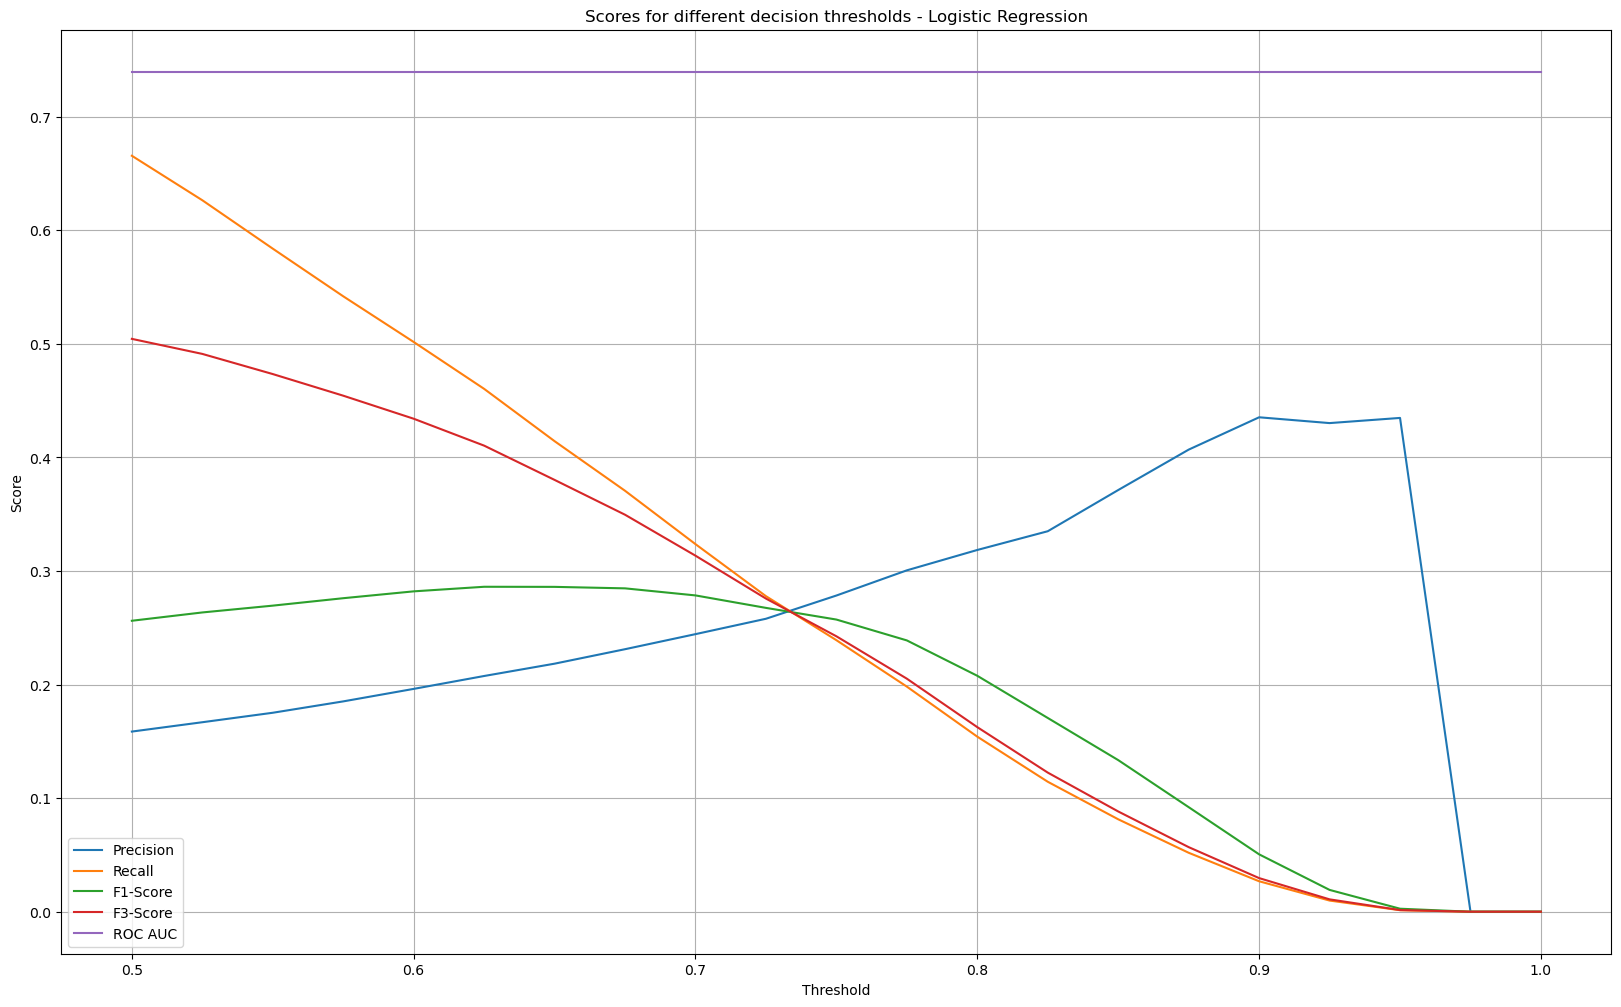

Meilleur seuil de décision pour Logistic Regression: 0.500 avec un F3-Score de 0.50439


Évaluation des seuils pour le modèle : CatBoost Classifier


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|   Threshold |   Precision |   Recall |   F1-Score |   F3-Score |   ROC AUC |
|------------:|------------:|---------:|-----------:|-----------:|----------:|
|     0.50000 |     0.17284 |  0.68127 |    0.27572 |    0.52641 |   0.76418 |
|     0.52500 |     0.18159 |  0.64397 |    0.28329 |    0.51327 |   0.76418 |
|     0.55000 |     0.19187 |  0.60680 |    0.29156 |    0.49891 |   0.76418 |
|     0.57500 |     0.20193 |  0.56511 |    0.29754 |    0.47897 |   0.76418 |
|     0.60000 |     0.21425 |  0.52715 |    0.30468 |    0.45997 |   0.76418 |
|     0.62500 |     0.22724 |  0.48772 |    0.31003 |    0.43756 |   0.76418 |
|     0.65000 |     0.24100 |  0.44498 |    0.31266 |    0.41025 |   0.76418 |
|     0.67500 |     0.25539 |  0.40263 |    0.31254 |    0.38068 |   0.76418 |
|     0.70000 |     0.27140 |  0.35816 |    0.30880 |    0.34706 |   0.76418 |
|     0.72500 |     0.28897 |  0.31276 |    0.30040 |    0.31020 |   0.76418 |
|     0.75000 |     0.30916 |  0.27054 |    0.28857 

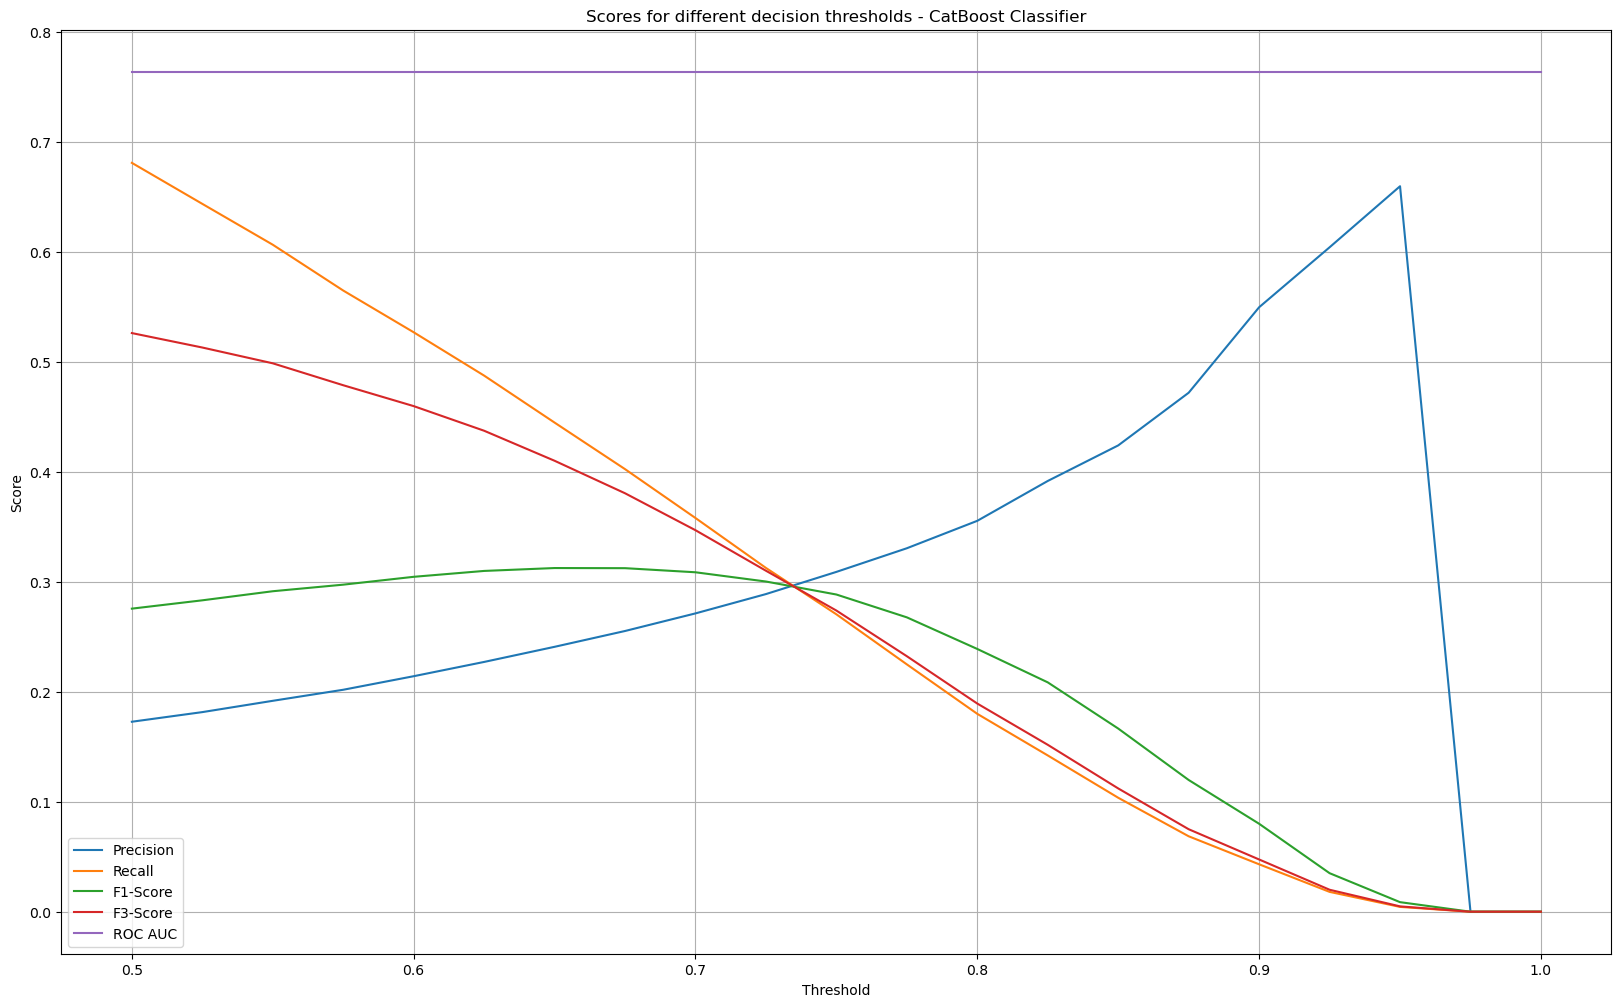

Meilleur seuil de décision pour CatBoost Classifier: 0.500 avec un F3-Score de 0.52641


Meilleurs hyperparamètres pour chaque modèle :
Modèle: Logistic Regression
Hyperparamètres: {'C': 1000, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Modèle: CatBoost Classifier
Hyperparamètres: {'auto_class_weights': 'Balanced', 'bagging_temperature': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'learning_rate': 0.1, 'loss_function': 'Logloss'}

Métriques pour les données d'entraînement :
| Model               |   Precision |   Recall |   F1 Score |   ROC AUC |   Score métier |
|:--------------------|------------:|---------:|-----------:|----------:|---------------:|
| Logistic Regression |     0.15904 |  0.67465 |    0.25741 |   0.74495 |        0.65367 |
| CatBoost Classifier |     0.17728 |  0.70807 |    0.28356 |   0.78235 |        0.68769 |

Métriques pour les données de test :
| Model               |   Precision |   Recall |   F1 Score |   ROC AUC |   Score métier |
|:---------------

In [222]:
# Appel de la fonction principale avec les chemins des fichiers
metrics_train, metrics_test = process_and_predict('data/application_train_split.csv', 'data/application_test_split.csv')


# Interpretation

## Nettoyage

In [226]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

def clean_data(train_file, test_file):
    """Nettoyer et préparer les données pour l'entraînement et le test."""
    print("Début du nettoyage des données...")
    
    app_train = pd.read_csv(train_file)
    app_test = pd.read_csv(test_file)
    
    label_encoders = {}
    for col in app_train.columns:
        if app_train[col].dtype == 'object':
            le = LabelEncoder()
            app_train[col] = le.fit_transform(app_train[col].astype(str))
            if col in app_test.columns:
                app_test[col] = le.transform(app_test[col].astype(str))
            label_encoders[col] = le
    
    app_train, app_test = feature_engineering(app_train, app_test)
    
    if 'TARGET' in app_train:
        train = app_train.drop(columns=['TARGET'])
        train_labels = app_train['TARGET']
    else:
        raise ValueError("La colonne 'TARGET' n'existe pas dans les données d'entraînement.")
    
    test = app_test.drop(columns=['SK_ID_CURR'])
    
    common_cols = train.columns.intersection(test.columns)
    train = train[common_cols]
    test = test[common_cols]
    
    imputer = SimpleImputer(strategy='median')
    train_numeric = imputer.fit_transform(train)
    test_numeric = imputer.transform(test)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_numeric = scaler.fit_transform(train_numeric)
    test_numeric = scaler.transform(test_numeric)
    
    train_final = pd.DataFrame(train_numeric, columns=common_cols)
    test_final = pd.DataFrame(test_numeric, columns=common_cols)
    
    print("Fin du nettoyage des données.")
    return train_final, test_final, train_labels, app_test['TARGET']


## Feature engineering

In [229]:
def feature_engineering(train, test):
    """Créer de nouvelles fonctionnalités à partir des données existantes."""
    train['AMT_ANNUITY/INCOME'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
    test['AMT_ANNUITY/INCOME'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
    
    train['credit_annuity_ratio'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']
    test['credit_annuity_ratio'] = test['AMT_CREDIT'] / test['AMT_ANNUITY']
    
    train['credit_goods_price_ratio'] = train['AMT_CREDIT'] / train['AMT_GOODS_PRICE']
    test['credit_goods_price_ratio'] = test['AMT_CREDIT'] / test['AMT_GOODS_PRICE']
    
    train['credit_downpayment'] = train['AMT_GOODS_PRICE'] - train['AMT_CREDIT']
    test['credit_downpayment'] = test['AMT_GOODS_PRICE'] - test['AMT_CREDIT']
    
    train['AGE_INT'] = (train['DAYS_BIRTH'] / -365).astype(int)
    test['AGE_INT'] = (test['DAYS_BIRTH'] / -365).astype(int)
    
    return train, test


In [231]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

def apply_rfe_to_feature_engineering(X, y, engineered_features):
    """Appliquer RFE uniquement sur les caractéristiques issues du feature engineering."""
    X_engineered = X[engineered_features]
    
    clf = LogisticRegression(max_iter=5000)
    cv = StratifiedKFold(5)
    
    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="accuracy",
        min_features_to_select=2,
        n_jobs=2
    )
    
    rfecv.fit(X_engineered, y)
    
    selected_features = [feature for feature, selected in zip(engineered_features, rfecv.support_) if selected]
    print(f"Optimal number of features: {rfecv.n_features_}")
    print(f"Selected features: {selected_features}")
    
    return selected_features


## Prediction temps

In [234]:
import time

def measure_prediction_time(model, X, n_estimations=1000):
    """Mesurer le temps de prédiction pour un nombre donné d'estimations."""
    start_time = time.time()
    for _ in range(n_estimations):
        model.predict(X)
    end_time = time.time()
    total_time = end_time - start_time
    return total_time


## HP

In [237]:
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

def search_hyperparameters(train_final, train_labels):
    """Rechercher les meilleurs hyperparamètres pour les modèles."""
    print("Début de la recherche des hyperparamètres...")
    
    models = {}
    
    # Définir le fbeta_scorer
    fbeta_scorer = make_scorer(fbeta_score, beta=10)

    # Logistic Regression
    log_reg_params = {
        'C': [1500,1750], 
        'solver': ['newton-cg', 'lbfgs'], 
        'penalty': ['l2'],
        'class_weight': ['balanced']
    }
    log_reg = LogisticRegression(max_iter=9000)
    log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring=fbeta_scorer)
    log_reg_grid.fit(train_final, train_labels)
    models['Logistic Regression'] = log_reg_grid.best_params_
    print("Fin de la recherche des logreg.")
    
    # CatBoost Classifier
    catboost_params = {
        'depth': [2, 3],
        'learning_rate': [0.1,0.15],
        'l2_leaf_reg': [7,6],
        'bagging_temperature': [0.3,0.35],
        'loss_function': ['Logloss'],
        'auto_class_weights': ['Balanced']
    }
    catboost_model = CatBoostClassifier(iterations=2500, auto_class_weights='Balanced', verbose=0)
    catboost_grid = GridSearchCV(catboost_model, catboost_params, cv=5, scoring=fbeta_scorer)
    catboost_grid.fit(train_final, train_labels)
    models['CatBoost Classifier'] = catboost_grid.best_params_
    print("Fin de la recherche des catboost.")
    
    print("Fin de la recherche des hyperparamètres.")
    return models


## Training

In [240]:
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

def train_models(train_final, train_labels, best_params):
    """Entraîner les modèles en utilisant les paramètres optimaux et RFE pour le feature engineering."""
    # Les caractéristiques issues du feature engineering
    engineered_features = [
        'AMT_ANNUITY/INCOME', 
        'credit_annuity_ratio', 
        'credit_goods_price_ratio', 
        'credit_downpayment', 
        'AGE_INT'
    ]
    
    # Appliquer RFE uniquement sur ces nouvelles caractéristiques
    selected_engineered_features = apply_rfe_to_feature_engineering(train_final, train_labels, engineered_features)
    
    # Conserver les autres caractéristiques non issues du feature engineering
    other_features = [col for col in train_final.columns if col not in engineered_features]
    
    # Créer une liste des caractéristiques finales à utiliser
    final_features = other_features + selected_engineered_features
    
    # Sélectionner les données d'entraînement finales
    X_train = train_final[final_features]
    
    # Entraîner les modèles avec les caractéristiques sélectionnées
    models = {}
    
    # Exemple de modèle : Logistic Regression
    clf = LogisticRegression(**best_params['Logistic Regression'])
    clf.fit(X_train, train_labels)
    models['Logistic Regression'] = clf
    
    # Exemple de modèle : CatBoost Classifier
    clf_catboost = CatBoostClassifier(**best_params['CatBoost Classifier'])
    clf_catboost.fit(X_train, train_labels, verbose=0)
    models['CatBoost Classifier'] = clf_catboost
    
    return models, final_features


## Evaluation seuil

In [243]:
import numpy as np  # Ajout de l'import manquant
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix
from tabulate import tabulate
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# Les autres fonctions restent les mêmes...

def evaluate_thresholds(models, X_test, y_test, beta=10):
    """Évaluer différents seuils de décision pour un modèle et afficher les résultats."""
    thresholds = np.arange(0.5, 1.025, 0.025)
    
    for model_name, model in models.items():
        print(f"\nÉvaluation des seuils pour le modèle : {model_name}")
        
        results = []
        for threshold in thresholds:
            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = (y_proba >= threshold).astype(int)
            
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_proba)
            fbeta = fbeta_score(y_test, y_pred, beta=beta)
            
            results.append([threshold, precision, recall, f1, fbeta, roc_auc])
        
        headers = ["Threshold", "Precision", "Recall", "F1-Score", f"F{beta}-Score", "ROC AUC"]
        results_table = tabulate(results, headers=headers, tablefmt="pipe", floatfmt=".5f")
        print(results_table)
        
        # Tracer le graphique du F-beta score en fonction du seuil de décision
        thresholds_list, precision_list, recall_list, f1_list, fbeta_list, roc_auc_list = zip(*results)
        
        plt.figure(figsize=(20, 12))
        plt.plot(thresholds_list, precision_list, label="Precision")
        plt.plot(thresholds_list, recall_list, label="Recall")
        plt.plot(thresholds_list, f1_list, label="F1-Score")
        plt.plot(thresholds_list, fbeta_list, label=f"F{beta}-Score")
        plt.plot(thresholds_list, roc_auc_list, label="ROC AUC")
        plt.xlabel("Threshold")
        plt.ylabel("Score")
        plt.title(f"Scores for different decision thresholds - {model_name}")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Identifier le meilleur seuil basé sur le F-beta score
        best_idx = np.argmax(fbeta_list)
        best_threshold = thresholds_list[best_idx]
        best_fbeta = fbeta_list[best_idx]
        
        print(f"Meilleur seuil de décision pour {model_name}: {best_threshold:.3f} avec un F{beta}-Score de {best_fbeta:.5f}\n")


## Evaluation Model

In [246]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, fbeta_score

def evaluate_models(models, train_final, train_labels, test_final, test_labels, selected_features):
    """Évaluer les modèles sur les ensembles de données d'entraînement et de test."""

    metrics_train = []
    metrics_test = []

    for model_name, model in models.items():
        # Évaluation sur l'ensemble d'entraînement
        train_preds = model.predict(train_final[selected_features])
        train_probs = model.predict_proba(train_final[selected_features])[:, 1]
        
        train_metrics = {
            'Model': model_name,
            'Precision': precision_score(train_labels, train_preds),
            'Recall': recall_score(train_labels, train_preds),
            'F1 Score': f1_score(train_labels, train_preds),
            'ROC AUC': roc_auc_score(train_labels, train_probs),
            'Score métier': fbeta_score(train_labels, train_preds, beta=10)
        }
        metrics_train.append(train_metrics)
        
        # Évaluation sur l'ensemble de test
        test_preds = model.predict(test_final[selected_features])
        test_probs = model.predict_proba(test_final[selected_features])[:, 1]
        
        test_metrics = {
            'Model': model_name,
            'Precision': precision_score(test_labels, test_preds),
            'Recall': recall_score(test_labels, test_preds),
            'F1 Score': f1_score(test_labels, test_preds),
            'ROC AUC': roc_auc_score(test_labels, test_probs),
            'Score métier': fbeta_score(test_labels, test_preds, beta=10)
        }
        metrics_test.append(test_metrics)

    return metrics_train, metrics_test


## Affichage

In [249]:
from tabulate import tabulate

def display_results(metrics_train, metrics_test, best_params):
    """Afficher les résultats des modèles avec tabulate, en incluant l'estimation des 1000 prédictions et en formatant les scores."""
    
    # Affichage des meilleurs hyperparamètres
    print("\nMeilleurs hyperparamètres pour chaque modèle :")
    for model_name, params in best_params.items():
        print(f"Modèle: {model_name}")
        print(f"Hyperparamètres: {params}")
    
    # Affichage des résultats pour les données d'entraînement
    if metrics_train and isinstance(metrics_train, list) and all(isinstance(d, dict) for d in metrics_train):
        headers_train = metrics_train[0].keys()
        results_table_train = tabulate(
            [[f"{value:.5f}" if isinstance(value, (float, int)) else value for value in d.values()] for d in metrics_train],
            headers=headers_train,
            tablefmt='pipe',
            floatfmt=".5f"
        )
        print("\nMétriques pour les données d'entraînement :")
        print(results_table_train)
    else:
        print("Erreur : Les données pour l'entraînement ne sont pas au format attendu ou sont vides.")
    
    # Affichage des résultats pour les données de test
    if metrics_test and isinstance(metrics_test, list) and all(isinstance(d, dict) for d in metrics_test):
        headers_test = metrics_test[0].keys()
        results_table_test = tabulate(
            [[f"{value:.5f}" if isinstance(value, (float, int)) else value for value in d.values()] for d in metrics_test],
            headers=headers_test,
            tablefmt='pipe',
            floatfmt=".5f"
        )
        print("\nMétriques pour les données de test :")
        print(results_table_test)
    else:
        print("Erreur : Les données pour le test ne sont pas au format attendu ou sont vides.")


## Importance

In [252]:
import shap
import numpy as np
import matplotlib.pyplot as plt

def plot_shap_force_plots(explainer, shap_values, X_train, selected_features, num_plots=10):
    """Affiche plusieurs SHAP force plots avec des valeurs SHAP arrondies et des figures élargies."""
    print("Affichage de plusieurs SHAP force plots (shap.force_plot)...")
    
    # Initialiser JavaScript pour SHAP
    shap.initjs()
    
    # Vérifier si expected_value est un scalaire ou un tableau
    expected_value = explainer.expected_value
    if isinstance(expected_value, list) or isinstance(expected_value, np.ndarray):
        expected_value = expected_value[0]  # Prendre la première valeur si c'est un tableau

    # Arrondir les valeurs SHAP
    shap_values_rounded = shap.Explanation(
        values=np.round(shap_values.values, 2),
        base_values=np.round(shap_values.base_values, 2),
        data=shap_values.data,
        feature_names=shap_values.feature_names
    )

    # Boucle pour afficher les plots pour les premières instances
    for i in range(min(num_plots, len(X_train))):
        plt.figure(figsize=(10, 5))  # Ajuster la taille de chaque figure individuellement

        # Utiliser le plot interactif de SHAP avec matplotlib
        shap.force_plot(
            expected_value,
            shap_values_rounded.values[i],  # Utilisation de l'instance i
            X_train.iloc[i],  # Utilisation de l'instance i
            feature_names=selected_features,
            matplotlib=True  # Utiliser le backend matplotlib
        )

        # Afficher le graphique avec plt.show()
        plt.show()

        # Fermer la figure pour éviter la superposition des graphes
        plt.close()


In [254]:
import shap
from IPython.display import display  # Utilisé pour l'affichage dans les notebooks Jupyter

def plot_shap_plots_force(shap_values):
    """Affiche le SHAP force plot avec shap.plots.force."""
    print("Affichage du SHAP force plot (shap.plots.force)...")
    
    # Initialiser JavaScript pour SHAP
    shap.initjs()
    
    # Utiliser IPython display pour forcer l'affichage dans un notebook
    display(shap.plots.force(shap_values[0]))  # Correctement utiliser shap.plots.force pour l'affichage interractif


In [256]:
def plot_shap_summary_plot(shap_values, X_train, selected_features):
    """Affichage du SHAP summary plot."""
    print("\nAffichage du SHAP summary plot...")
    shap.summary_plot(shap_values, X_train, feature_names=selected_features)
    plt.show()


In [258]:
import shap
import pandas as pd

def interpret_model_importance(models, X_train, y_train, selected_features):
    """Interpréter l'importance des variables pour les meilleurs modèles."""
    
    for model_name, model in models.items():
        print(f"\nInterprétation de l'importance des variables pour le modèle : {model_name}")
        
        # Si le modèle est une régression logistique
        if hasattr(model, 'coef_'):  
            feature_importance = model.coef_[0]
            importance_df = pd.DataFrame({
                'Feature': selected_features,
                'Coefficient': feature_importance
            }).sort_values(by='Coefficient', ascending=False)
            print("\nImportance des variables (coefficients de régression) :")
            print(importance_df)
        
        # Si le modèle est un CatBoostClassifier (ou un autre modèle avec feature_importances_)
        elif hasattr(model, 'feature_importances_'):  
            feature_importance = model.feature_importances_
            importance_df = pd.DataFrame({
                'Feature': selected_features,
                'Importance': feature_importance
            }).sort_values(by='Importance', ascending=False)
            print("\nImportance des variables (feature importances) :")
            print(importance_df)
        
        # Utilisation de SHAP pour interpréter l'importance des variables
        explainer = shap.Explainer(model, X_train)
        shap_values = explainer(X_train)
        
        # Affichage des graphiques SHAP
        plot_shap_force_plots(explainer, shap_values, X_train, selected_features)
        plot_shap_plots_force(shap_values)
        plot_shap_summary_plot(shap_values, X_train, selected_features)


## Fonction principale

In [261]:
def process_and_predict(train_file, test_file):
    """Fonction principale pour nettoyer les données, rechercher les hyperparamètres,
    entraîner les modèles, et évaluer les performances."""
    print("Début du traitement et des prédictions...")
    
    # Nettoyage des données
    train_final, test_final, train_labels, test_labels = clean_data(train_file, test_file)
    
    # Recherche des hyperparamètres
    best_params = search_hyperparameters(train_final, train_labels)
    
    # Entraînement des modèles
    models, selected_features = train_models(train_final, train_labels, best_params)
    
    # Évaluation des performances
    metrics_train, metrics_test = evaluate_models(models, train_final, train_labels, test_final, test_labels, selected_features)
    
    # Évaluation des seuils de décision
    evaluate_thresholds(models, test_final, test_labels, beta=3)
    
    # Affichage des résultats
    display_results(metrics_train, metrics_test, best_params)
    
    # Interprétation de l'importance des variables
    interpret_model_importance(models, train_final, train_labels, selected_features)

    return metrics_train, metrics_test


## Appel

Début du traitement et des prédictions...
Début du nettoyage des données...
Fin du nettoyage des données.
Début de la recherche des hyperparamètres...


/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Fin de la recherche des logreg.
Fin de la recherche des catboost.
Fin de la recherche des hyperparamètres.
Optimal number of features: 5
Selected features: ['AMT_ANNUITY/INCOME', 'credit_annuity_ratio', 'credit_goods_price_ratio', 'credit_downpayment', 'AGE_INT']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(



Évaluation des seuils pour le modèle : Logistic Regression
|   Threshold |   Precision |   Recall |   F1-Score |   F3-Score |   ROC AUC |
|------------:|------------:|---------:|-----------:|-----------:|----------:|
|     0.50000 |     0.16052 |  0.67145 |    0.25910 |    0.50933 |   0.74185 |
|     0.52500 |     0.16832 |  0.63003 |    0.26566 |    0.49441 |   0.74185 |
|     0.55000 |     0.17755 |  0.59020 |    0.27298 |    0.47890 |   0.74185 |
|     0.57500 |     0.18778 |  0.55064 |    0.28005 |    0.46147 |   0.74185 |
|     0.60000 |     0.19782 |  0.50551 |    0.28436 |    0.43746 |   0.74185 |
|     0.62500 |     0.20936 |  0.46422 |    0.28858 |    0.41385 |   0.74185 |
|     0.65000 |     0.22264 |  0.42427 |    0.29203 |    0.38903 |   0.74185 |
|     0.67500 |     0.23460 |  0.37754 |    0.28938 |    0.35586 |   0.74185 |
|     0.70000 |     0.24832 |  0.33360 |    0.28471 |    0.32252 |   0.74185 |
|     0.72500 |     0.26267 |  0.28767 |    0.27460 |    0.28496 |   0.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


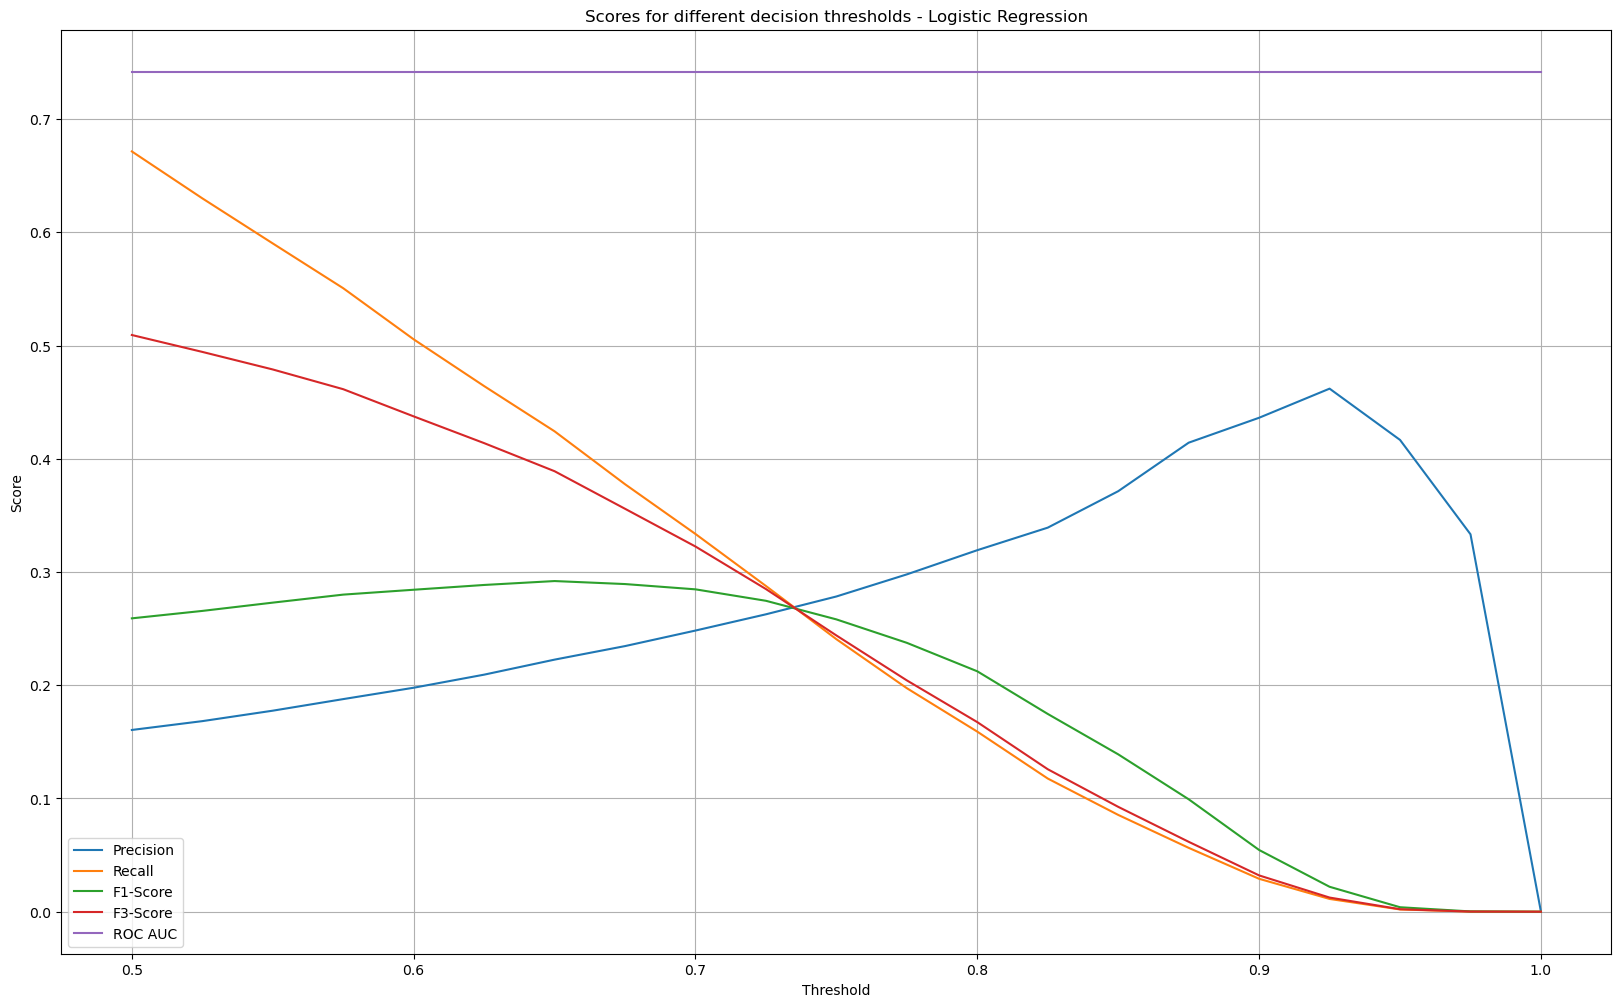

Meilleur seuil de décision pour Logistic Regression: 0.500 avec un F3-Score de 0.50933


Évaluation des seuils pour le modèle : CatBoost Classifier


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|   Threshold |   Precision |   Recall |   F1-Score |   F3-Score |   ROC AUC |
|------------:|------------:|---------:|-----------:|-----------:|----------:|
|     0.50000 |     0.17284 |  0.68127 |    0.27572 |    0.52641 |   0.76418 |
|     0.52500 |     0.18159 |  0.64397 |    0.28329 |    0.51327 |   0.76418 |
|     0.55000 |     0.19187 |  0.60680 |    0.29156 |    0.49891 |   0.76418 |
|     0.57500 |     0.20193 |  0.56511 |    0.29754 |    0.47897 |   0.76418 |
|     0.60000 |     0.21425 |  0.52715 |    0.30468 |    0.45997 |   0.76418 |
|     0.62500 |     0.22724 |  0.48772 |    0.31003 |    0.43756 |   0.76418 |
|     0.65000 |     0.24100 |  0.44498 |    0.31266 |    0.41025 |   0.76418 |
|     0.67500 |     0.25539 |  0.40263 |    0.31254 |    0.38068 |   0.76418 |
|     0.70000 |     0.27140 |  0.35816 |    0.30880 |    0.34706 |   0.76418 |
|     0.72500 |     0.28897 |  0.31276 |    0.30040 |    0.31020 |   0.76418 |
|     0.75000 |     0.30916 |  0.27054 |    0.28857 

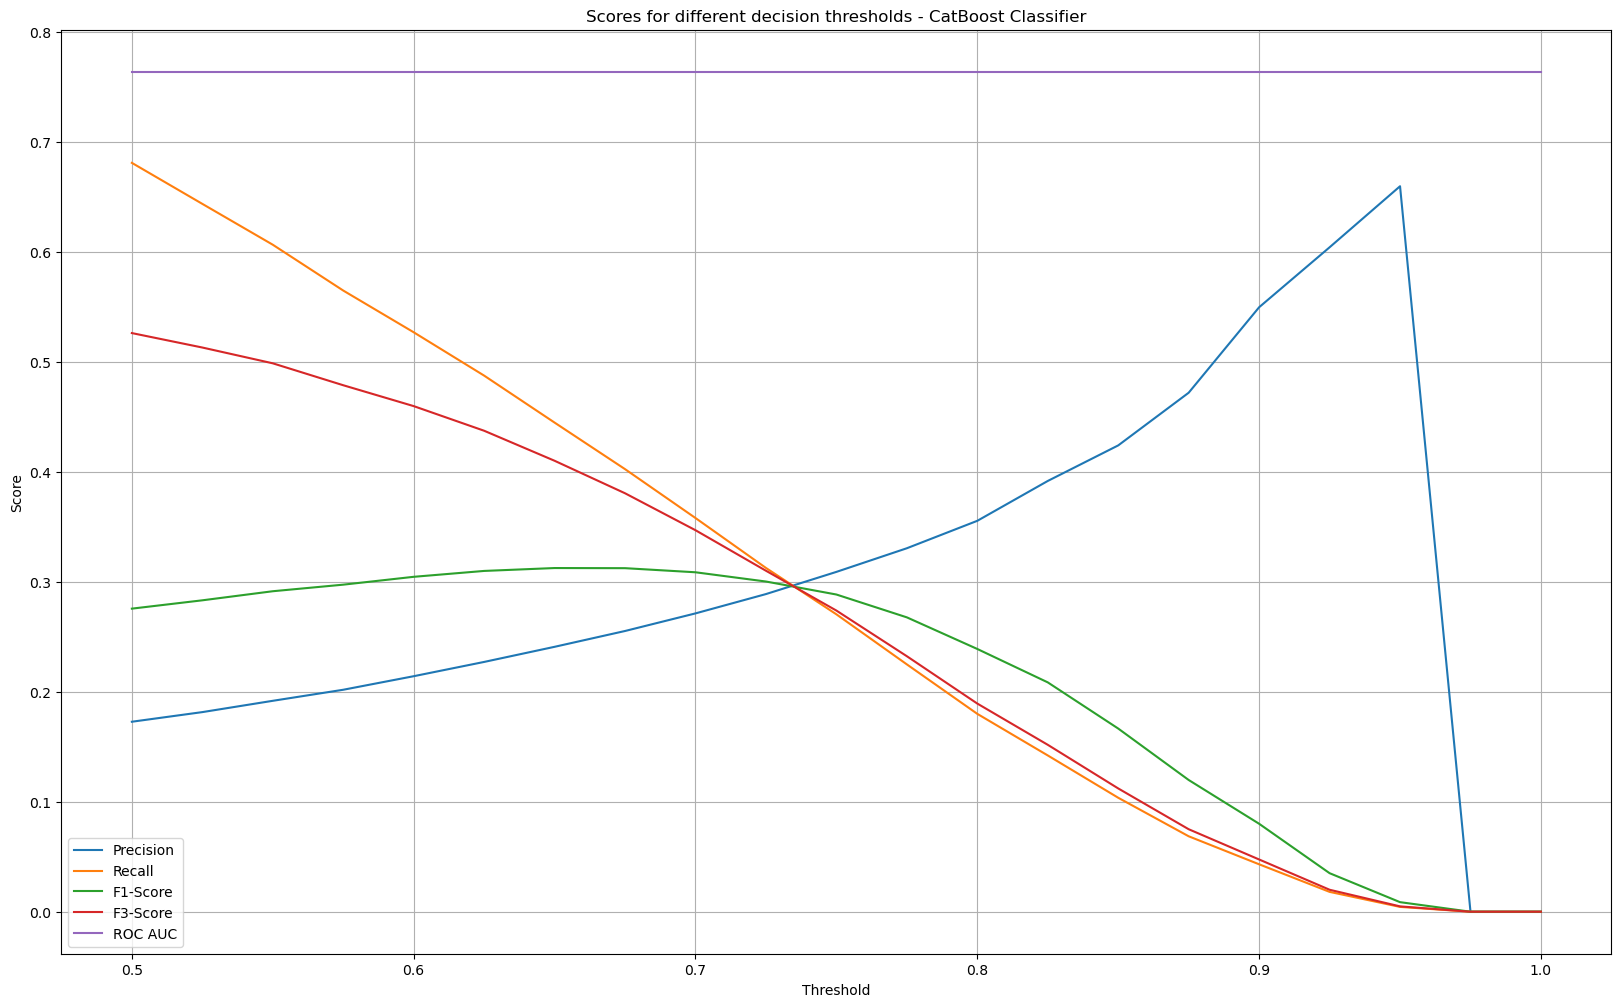

Meilleur seuil de décision pour CatBoost Classifier: 0.500 avec un F3-Score de 0.52641


Meilleurs hyperparamètres pour chaque modèle :
Modèle: Logistic Regression
Hyperparamètres: {'C': 1750, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
Modèle: CatBoost Classifier
Hyperparamètres: {'auto_class_weights': 'Balanced', 'bagging_temperature': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'learning_rate': 0.1, 'loss_function': 'Logloss'}

Métriques pour les données d'entraînement :
| Model               |   Precision |   Recall |   F1 Score |   ROC AUC |   Score métier |
|:--------------------|------------:|---------:|-----------:|----------:|---------------:|
| Logistic Regression |     0.16014 |  0.67702 |    0.25901 |   0.74864 |        0.65605 |
| CatBoost Classifier |     0.17728 |  0.70807 |    0.28356 |   0.78235 |        0.68769 |

Métriques pour les données de test :
| Model               |   Precision |   Recall |   F1 Score |   ROC AUC |   Score métier |
|:-----------

<Figure size 1000x500 with 0 Axes>

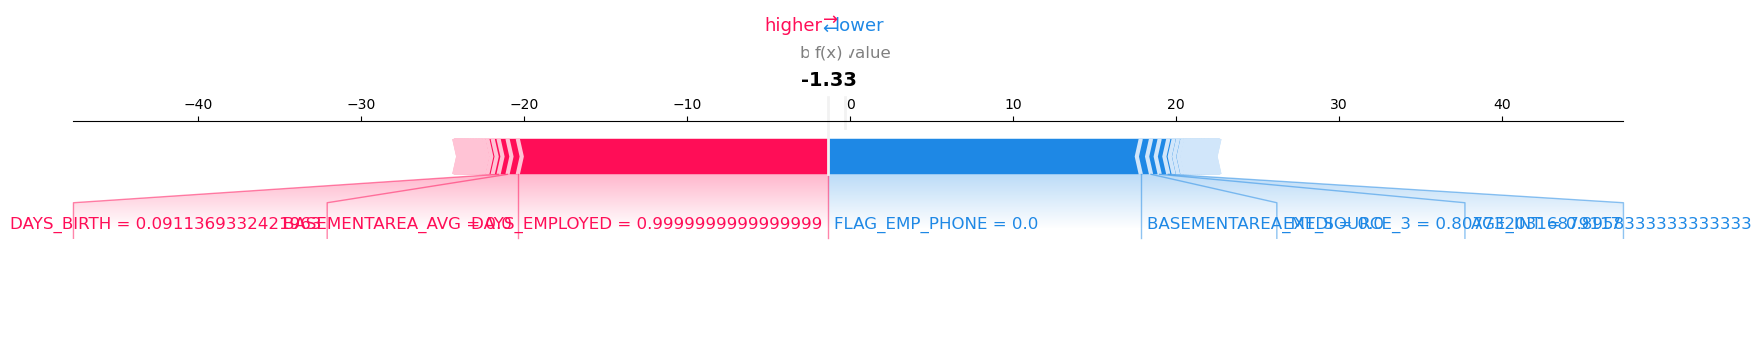

<Figure size 1000x500 with 0 Axes>

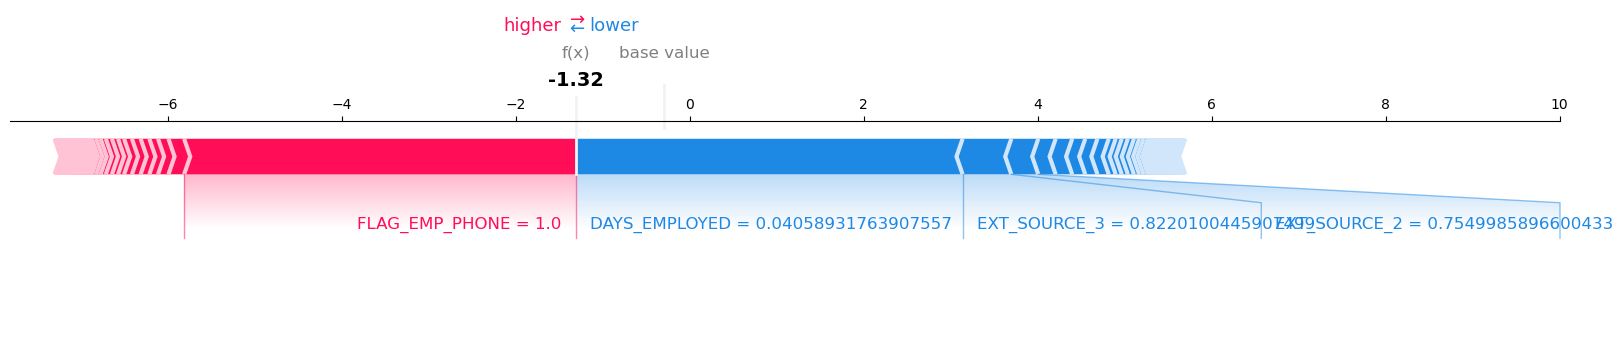

<Figure size 1000x500 with 0 Axes>

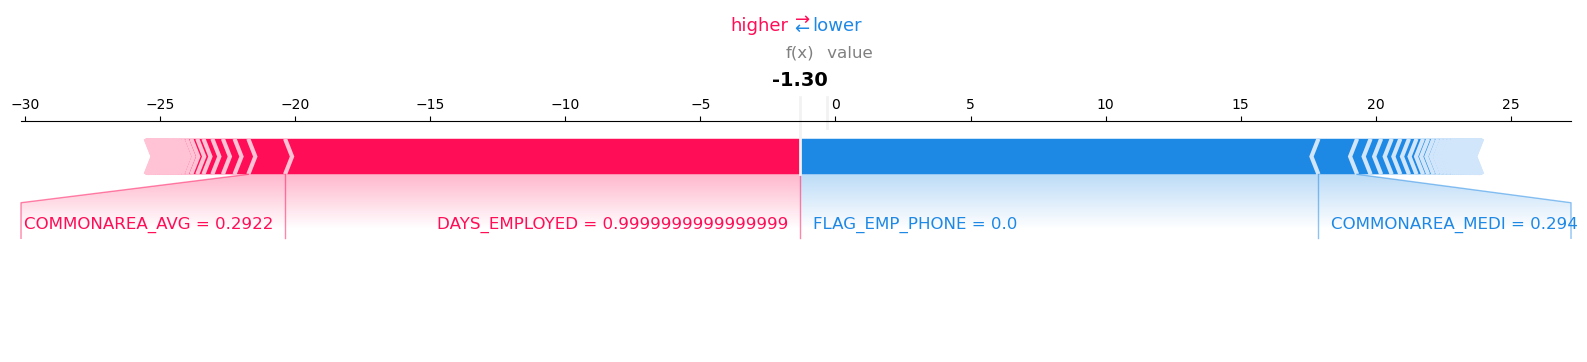

<Figure size 1000x500 with 0 Axes>

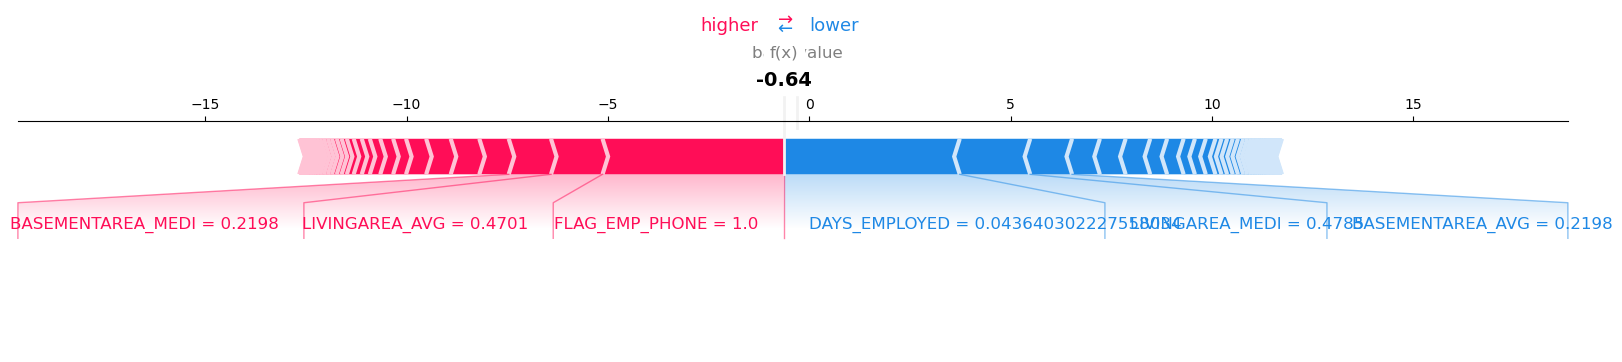

<Figure size 1000x500 with 0 Axes>

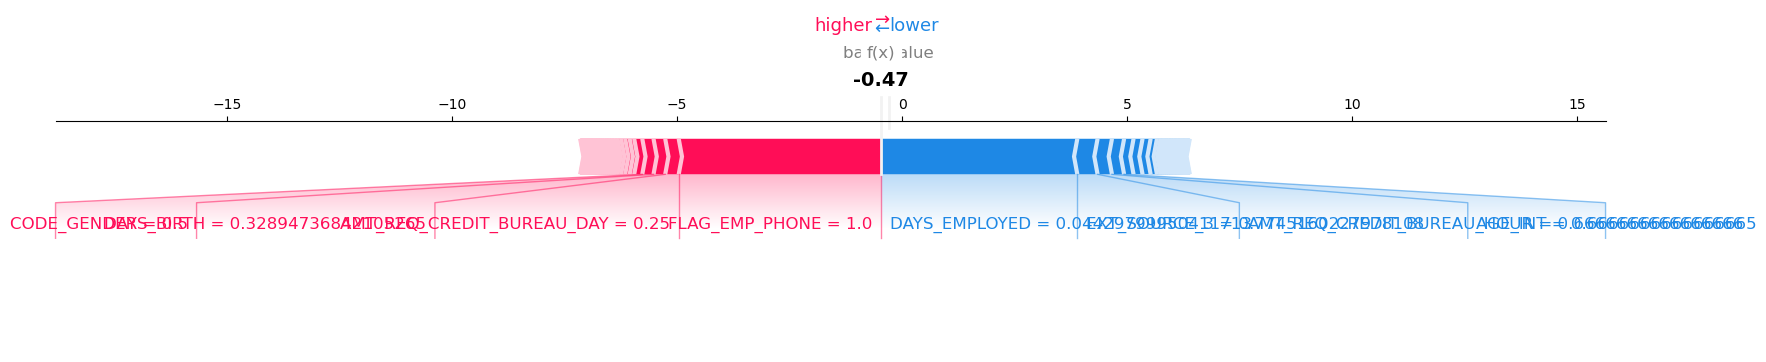

<Figure size 1000x500 with 0 Axes>

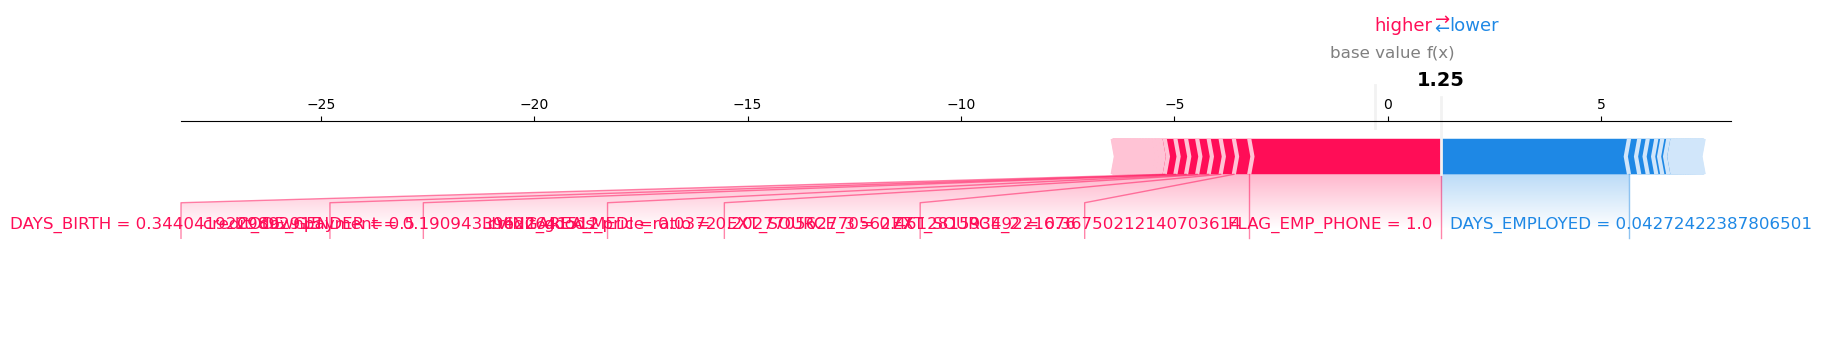

<Figure size 1000x500 with 0 Axes>

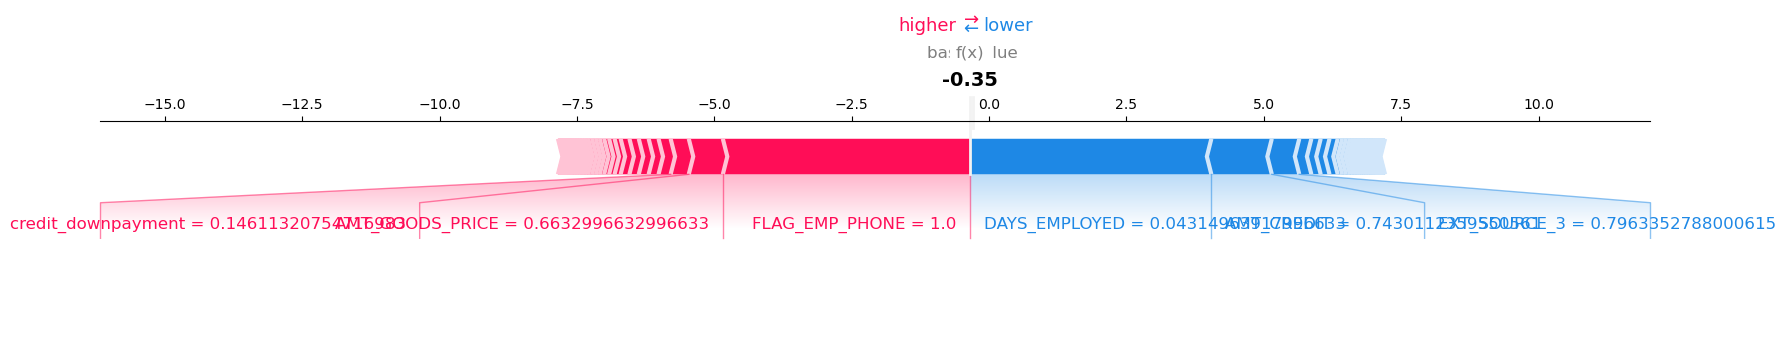

<Figure size 1000x500 with 0 Axes>

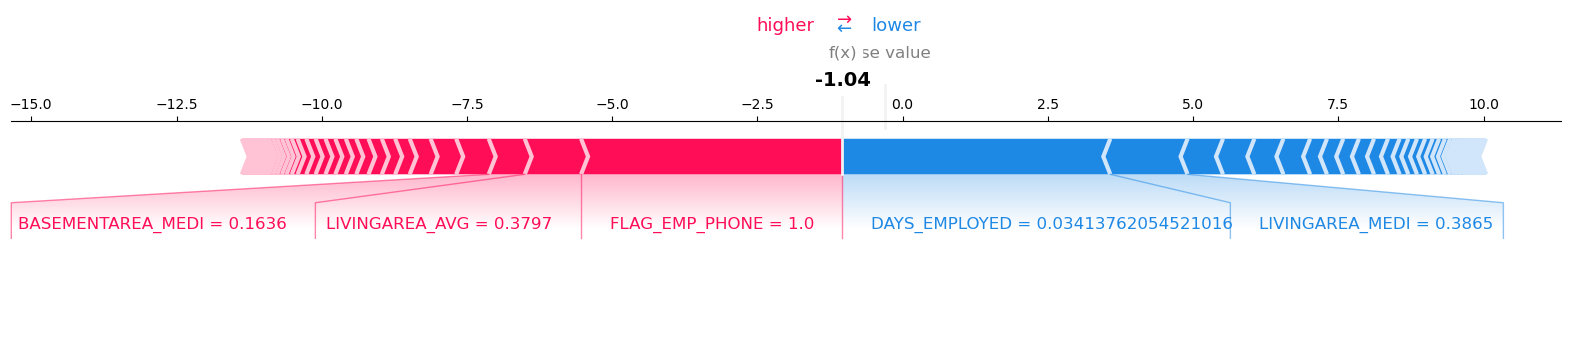

<Figure size 1000x500 with 0 Axes>

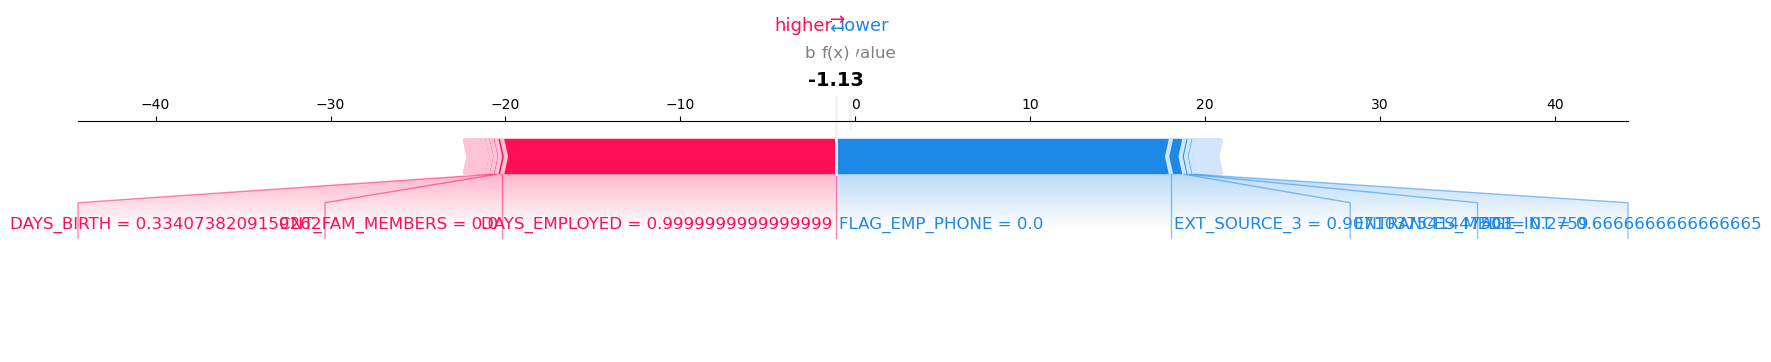

<Figure size 1000x500 with 0 Axes>

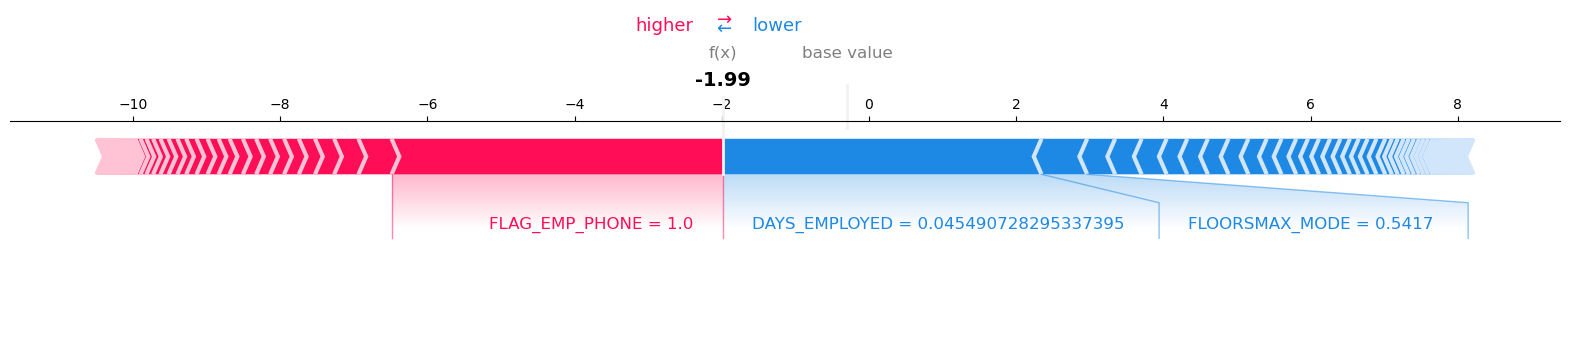

Affichage du SHAP force plot (shap.plots.force)...



Affichage du SHAP summary plot...


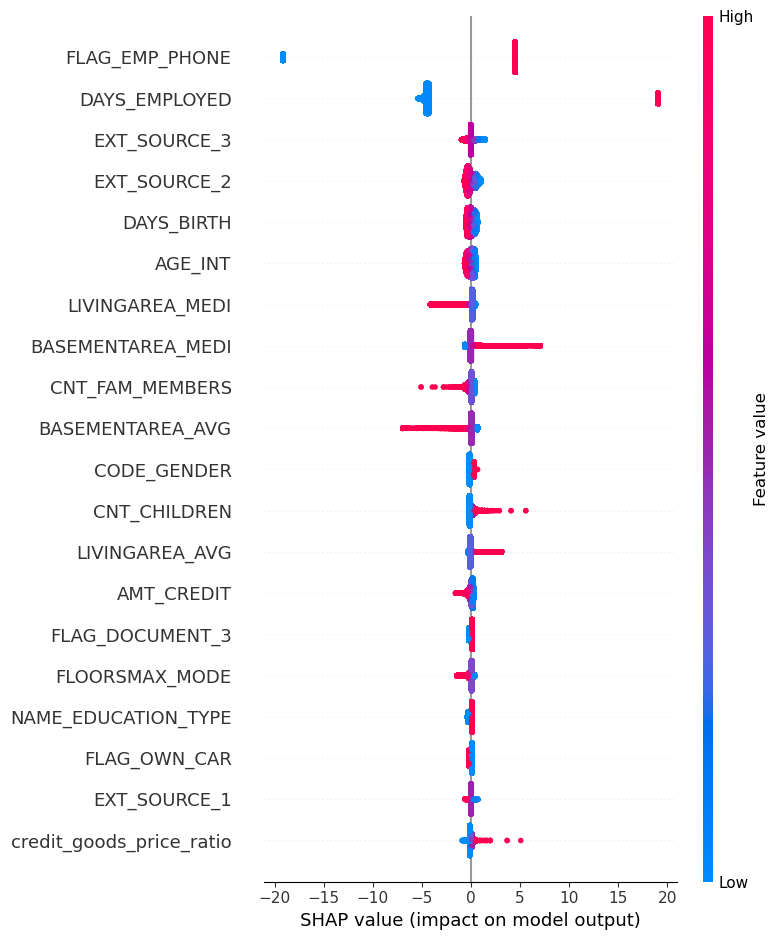


Interprétation de l'importance des variables pour le modèle : CatBoost Classifier

Importance des variables (feature importances) :
                  Feature  Importance
41           EXT_SOURCE_3   21.418587
40           EXT_SOURCE_2   18.217730
121  credit_annuity_ratio   11.196656
39           EXT_SOURCE_1    7.613170
15             DAYS_BIRTH    3.143862
..                    ...         ...
111      FLAG_DOCUMENT_19    0.000000
100       FLAG_DOCUMENT_8    0.000000
101       FLAG_DOCUMENT_9    0.000000
102      FLAG_DOCUMENT_10    0.000000
20             FLAG_MOBIL    0.000000

[125 rows x 2 columns]


100%|===================| 215162/215257 [13:35<00:00]        

Affichage de plusieurs SHAP force plots (shap.force_plot)...


<Figure size 1000x500 with 0 Axes>

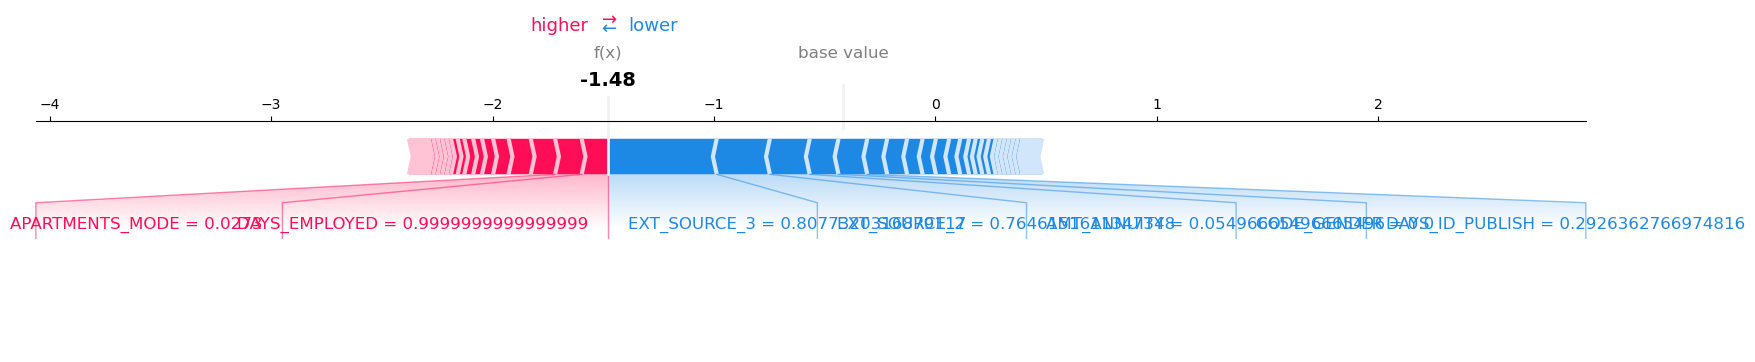

<Figure size 1000x500 with 0 Axes>

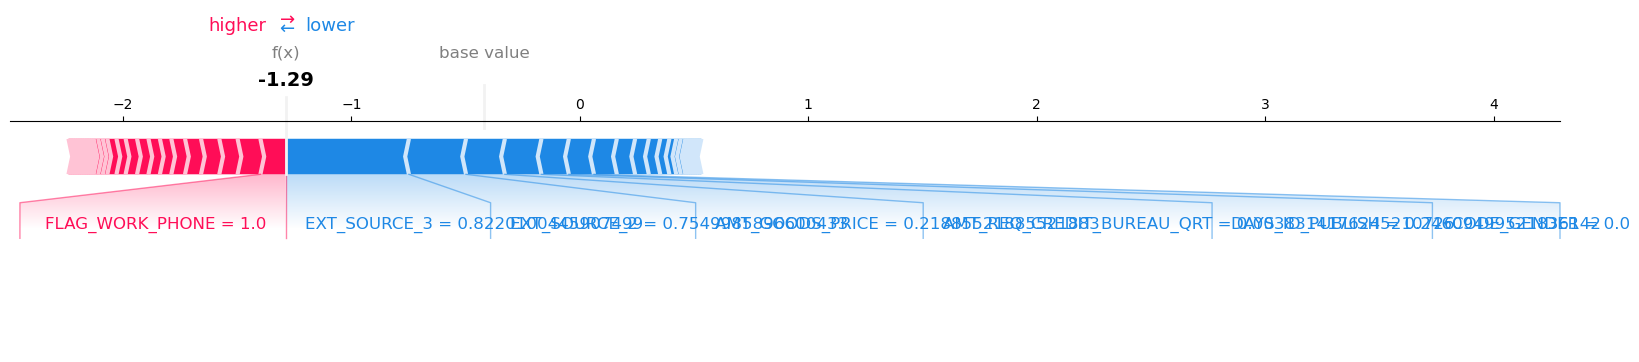

<Figure size 1000x500 with 0 Axes>

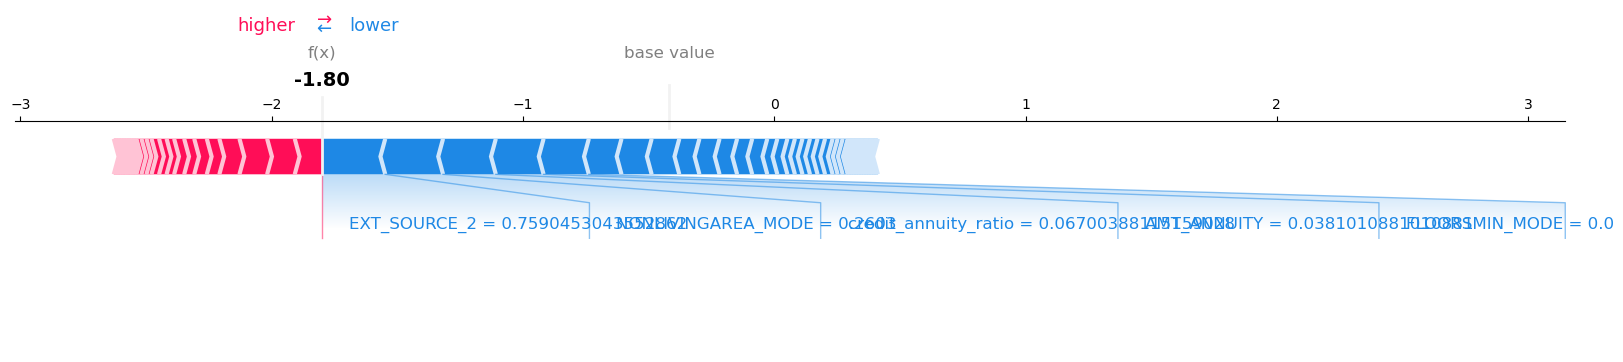

<Figure size 1000x500 with 0 Axes>

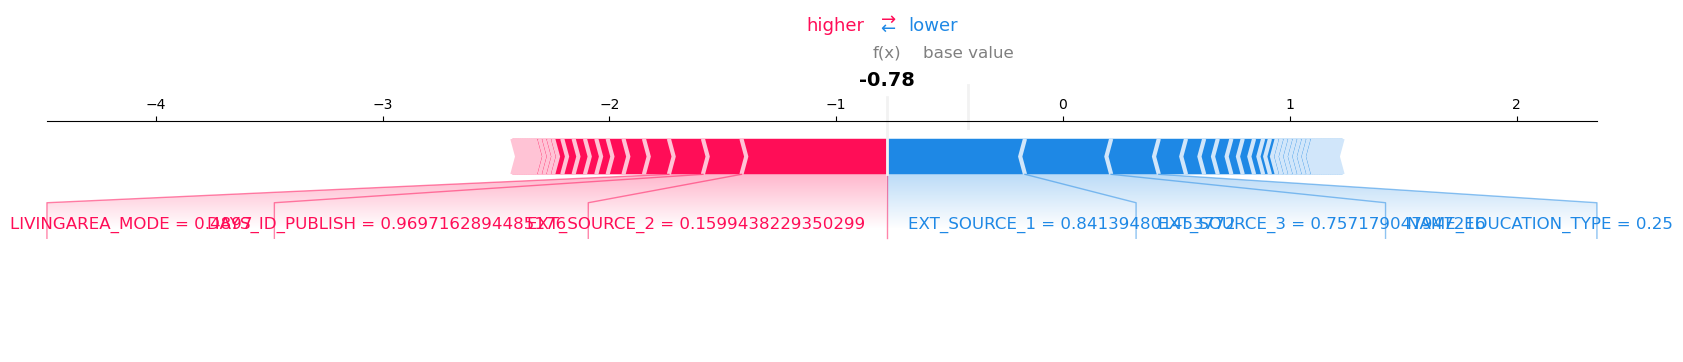

<Figure size 1000x500 with 0 Axes>

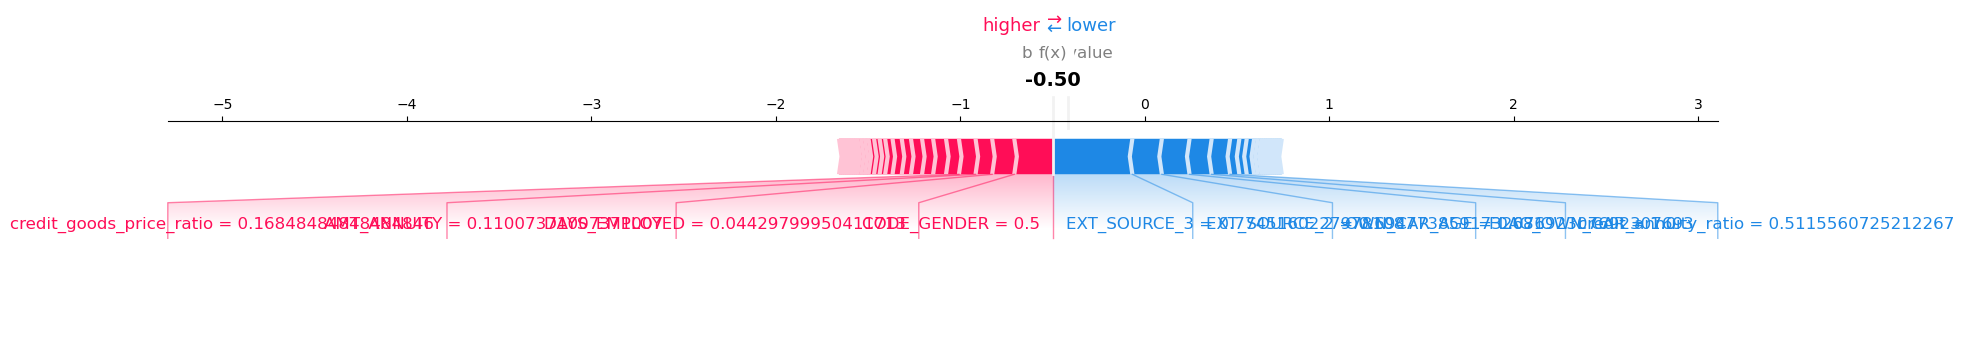

<Figure size 1000x500 with 0 Axes>

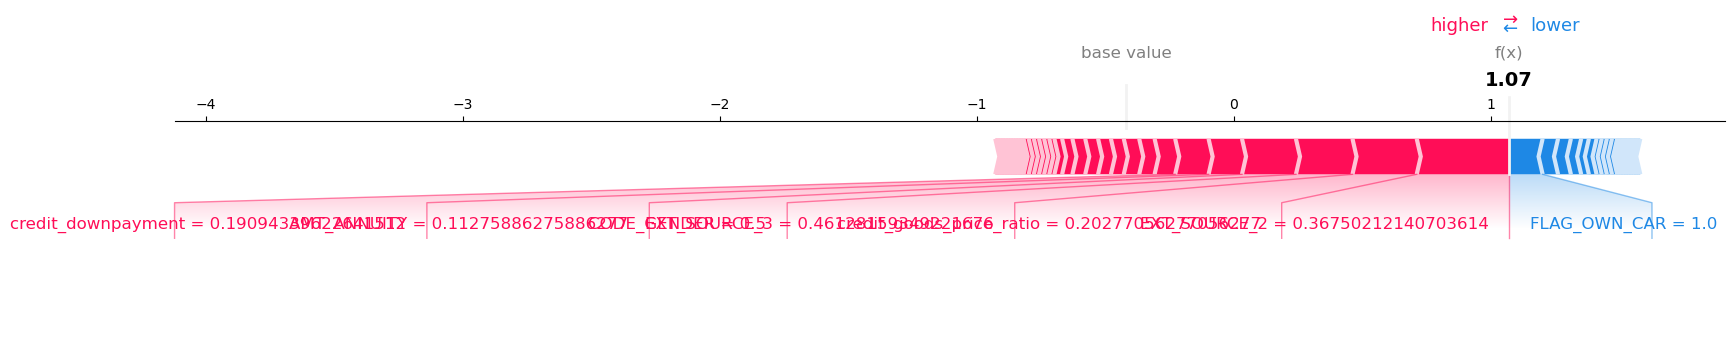

<Figure size 1000x500 with 0 Axes>

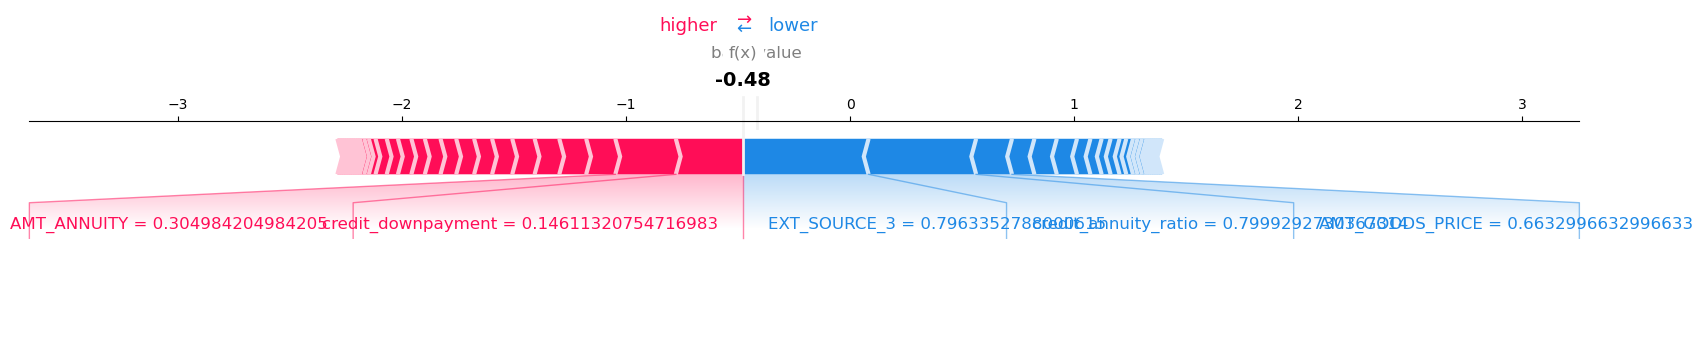

<Figure size 1000x500 with 0 Axes>

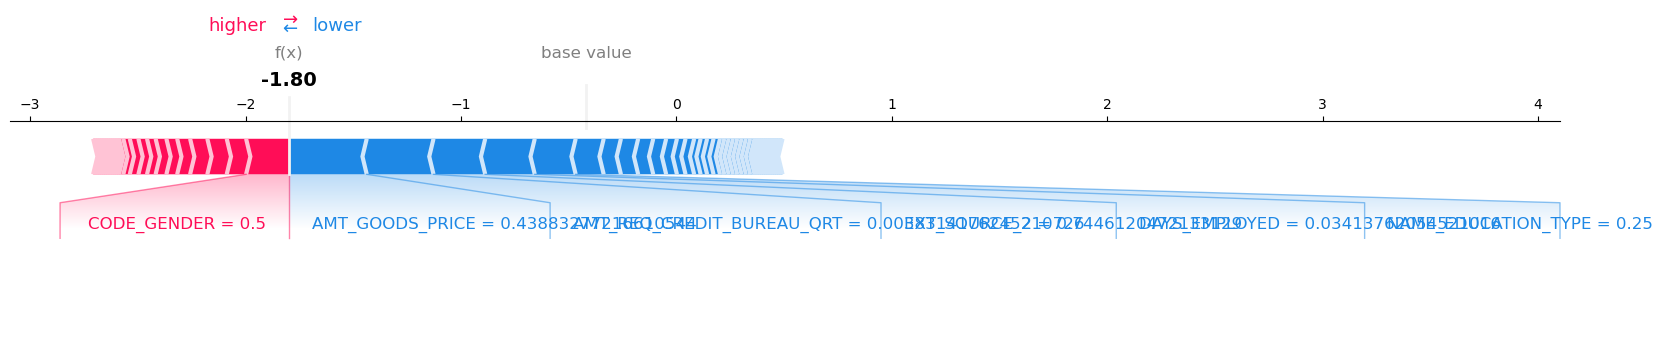

<Figure size 1000x500 with 0 Axes>

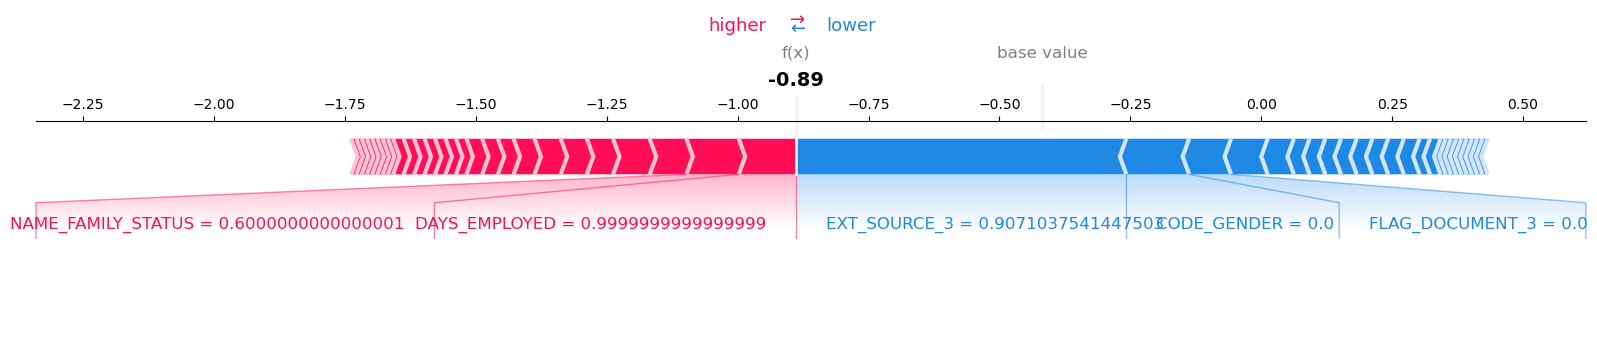

<Figure size 1000x500 with 0 Axes>

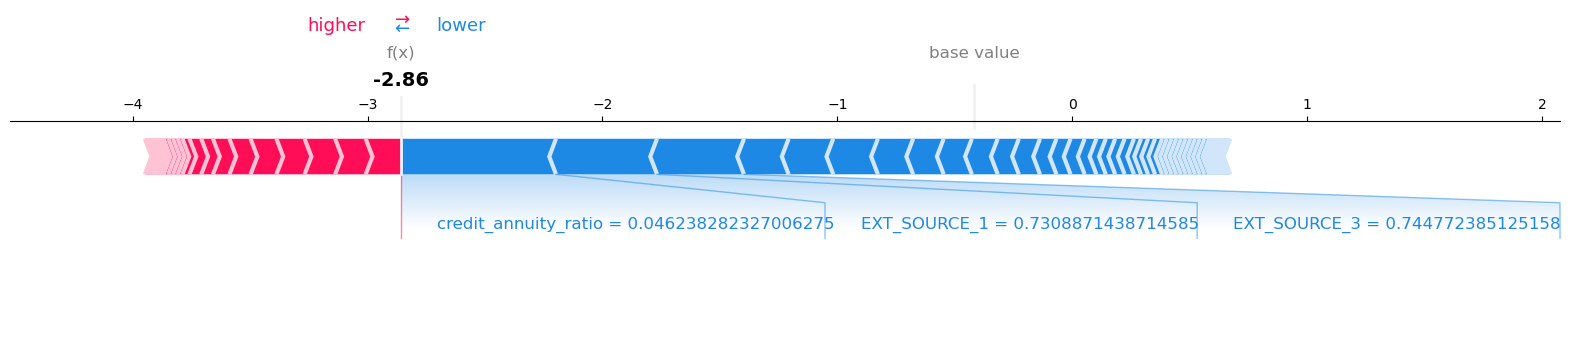

Affichage du SHAP force plot (shap.plots.force)...



Affichage du SHAP summary plot...


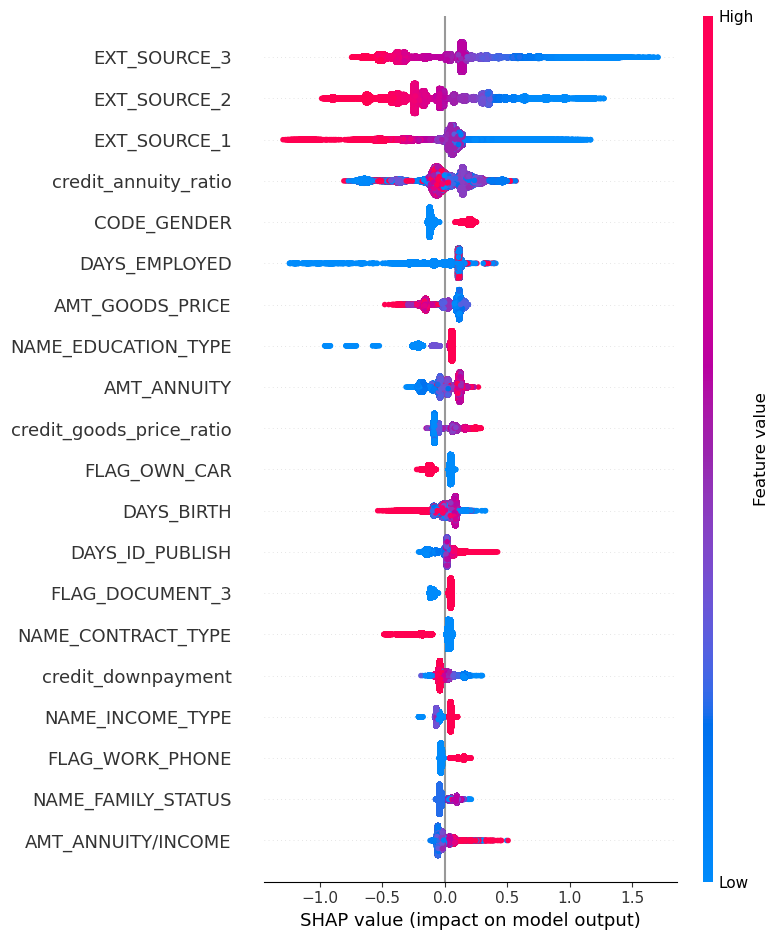

In [264]:
# Appel de la fonction principale avec les chemins des fichiers
metrics_train, metrics_test = process_and_predict('data/application_train_split.csv', 'data/application_test_split.csv')
